In [ ]:
# DEBUG: What's actually in our matrices?
print("=== DEBUGGING THE CLUSTERING ISSUE ===")

print(f"\n1. Input data X shape: {X.shape}")
print(f"   X mean: {X.mean():.6f}, std: {X.std():.6f}")
print(f"   X sparsity (zeros): {(X == 0).float().mean():.3f}")
print(f"   X range: [{X.min():.6f}, {X.max():.6f}]")

print(f"\n2. Similarity matrices:")
print(f"   S_dir shape: {S_dir.shape}, range: [{S_dir.min():.3f}, {S_dir.max():.3f}]")
print(f"   S_corr shape: {S_corr.shape}, range: [{S_corr.min():.3f}, {S_corr.max():.3f}]") 
print(f"   S_co shape: {S_co.shape}, range: [{S_co.min():.3f}, {S_co.max():.3f}]")

print(f"\n3. Fused similarity:")
print(f"   S_fused range: [{S_fused.min():.6f}, {S_fused.max():.6f}]")
print(f"   S_fused mean: {S_fused.mean():.6f}, std: {S_fused.std():.6f}")

print(f"\n4. Affinity matrix A:")
print(f"   A range: [{A.min():.6f}, {A.max():.6f}]")
print(f"   A sparsity (zeros): {(A == 0).float().mean():.3f}")
print(f"   A mean: {A.mean():.6f}")

# Check eigenvalues directly
L_norm, _ = MULTI_METRIC_RESULTS["eigenvalues_multi"], None
if hasattr(details_multi, 'get') and details_multi.get("eigenvalues") is not None:
    evals = details_multi["eigenvalues"][:20]  # first 20 eigenvalues
    print(f"\n5. First 20 eigenvalues of Laplacian:")
    print([f"{e:.4f}" for e in evals])
    
    # Manual eigengap calculation
    gaps = np.diff(evals[:10])
    print(f"\n6. First 10 eigengaps:")
    print([f"{g:.4f}" for g in gaps])
    print(f"   Largest gap at position: {np.argmax(gaps)} (gives k={np.argmax(gaps)+1})")

# Check if graph is connected
row_sums = A.sum(dim=1)
isolated_nodes = (row_sums == 0).sum()
print(f"\n7. Graph connectivity:")
print(f"   Isolated nodes (zero row sum): {isolated_nodes}")
print(f"   Min/max row sum: {row_sums.min():.6f} / {row_sums.max():.6f}")

print("\n=== END DEBUG ===\n")

In [ ]:
# Force override the clustering weights
W_DIR = 0.1
W_CORR = 0.1  
W_COACT = 0.8
print(f"NEW weights set: W_DIR={W_DIR}, W_CORR={W_CORR}, W_COACT={W_COACT}")

In [1]:
# Setup: ensure SciPy is available
import importlib, sys, subprocess

try:
    importlib.import_module("scipy")
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scipy"])


# Environment Setup
run and restart session

1.  **Clone Github Repo:**

In [2]:
!git clone -b feature/clustering-sjcs https://github.com/Chinyemba-ck/sjcs-spd

fatal: destination path 'sjcs-spd' already exists and is not an empty directory.


In [3]:
%cd sjcs-spd

/Users/samanseshadri/Desktop/Algo-2025/sjcs-spd


2.  **Install core dependencies**

In [4]:
# Install core dependencies
!pip install torch numpy matplotlib wandb pyyaml tqdm einops fire jaxtyping python-dotenv datasets torchvision beartype typeguard muutils

In [5]:
!make install

uv sync --no-dev
Resolved 170 packages in 9ms
Audited 115 packages in 1ms


3.  **Install SPD package**

In [6]:
!pip install -e .

Obtaining file:///Users/samanseshadri/Desktop/Algo-2025/sjcs-spd
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Cloning https://github.com/goodfire-ai/simple_stories_train.git (to revision dev) to /private/var/folders/4h/cj17vbgs0pj4f21bf87tyth00000gn/T/pip-install-3qytatq3/simple-stories-train_deaf5af5b6da448cbb318a05c41ab039
  Running command git clone --filter=blob:none --quiet https://github.com/goodfire-ai/simple_stories_train.git /private/var/folders/4h/cj17vbgs0pj4f21bf87tyth00000gn/T/pip-install-3qytatq3/simple-stories-train_deaf5af5b6da448cbb318a05c41ab039
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  branch 'dev' set up to track 'origin/dev'.
  Resolved https://github.com/goodfire-ai/simple_stories_train.git to commit 709631de67e774e2d3f2b13472c87788ff642d09
  Installing

# Choose SPD Run



In [7]:
# %%
from spd.clustering.merge import merge_iteration, merge_iteration_ensemble
from spd.clustering.merge_config import MergeConfig
from spd.clustering.merge_history import MergeHistory, MergeHistoryEnsemble
from spd.clustering.merge_sweep import sweep_multiple_parameters
from spd.clustering.plotting.merge import (
    plot_dists_distribution,
    plot_merge_iteration,
)

from typing import Any

import matplotlib.pyplot as plt
import torch
from muutils.dbg import dbg_auto
from torch import Tensor

from spd.clustering.activations import (
    ProcessedActivations,
    component_activations,
    process_activations,
)

from spd.clustering.plotting.activations import plot_activations

from spd.configs import Config
from spd.experiments.resid_mlp.resid_mlp_dataset import ResidMLPDataset
from spd.models.component_model import ComponentModel, SPDRunInfo
from spd.registry import EXPERIMENT_REGISTRY
from spd.utils.data_utils import DatasetGeneratedDataLoader

DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"

from spd.registry import EXPERIMENT_REGISTRY

# Then check available experiments:
print("Available experiments:")
for key in EXPERIMENT_REGISTRY.keys():
    print(f"  {key}: {EXPERIMENT_REGISTRY[key].canonical_run}")

/Users/samanseshadri/Desktop/Algo-2025/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Available experiments:
  tms_5-2: wandb:goodfire/spd/runs/qndu7oz4
  tms_5-2-id: wandb:goodfire/spd/runs/z6wxr9vk
  tms_40-10: wandb:goodfire/spd/runs/pq2r77l5
  tms_40-10-id: wandb:goodfire/spd/runs/0sz0scrh
  resid_mlp1: wandb:goodfire/spd/runs/glbtwl6g
  resid_mlp2: wandb:goodfire/spd/runs/84yirdkb
  resid_mlp3: wandb:goodfire/spd/runs/xawvyhq3
  ss_llama: None
  ss_gpt2: None
  gpt2: None
  ss_gpt2_simple: None
  ss_gpt2_simple_noln: None


In [8]:
# %%
# Load model
# ============================================================
import os, wandb
os.environ["WANDB_API_KEY"] = "54f7e3c7164a9afb5542d816ae5dd193d96c8915"
wandb.login(key=os.environ["WANDB_API_KEY"])

_CANONICAL_RUN: str | None = EXPERIMENT_REGISTRY["resid_mlp3"].canonical_run
assert _CANONICAL_RUN is not None, "No canonical run found for experiment"
SPD_RUN: SPDRunInfo = SPDRunInfo.from_path(_CANONICAL_RUN)

MODEL: ComponentModel = ComponentModel.from_pretrained(SPD_RUN.checkpoint_path)
MODEL.to(DEVICE)
SPD_CONFIG: Config = SPD_RUN.config

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/samanseshadri/.netrc
wandb: Currently logged in as: ckalenga (SJCS-SPD) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
figures_fns is deprecated, but has value: [{'extra_kwargs': {}, 'name': 'ci_histograms'}, {'extra_kwargs': {}, 'name': 'mean_component_activation_counts'}, {'extra_kwargs': {'dense_patterns': ['layers.*.mlp_out'], 'identity_patterns': ['layers.*.mlp_in']}, 'name': 'permuted_ci_plots'}, {'extra_kwargs': {}, 'name': 'uv_plots'}]. Removing from config.
image_freq is deprecated, but has value: 5000. Removing from config.
image_on_first_step is deprecated, but has value: True. Removing from config.
metrics_fns is deprecated, but has value: [{'extra_kwargs': {}, 'name': 'ci

API Key = 54f7e3c7164a9afb5542d816ae5dd193d96c8915


# Upper-half of cluster_resid_mlp.py


In [9]:
# %%
# Setup dataset and dataloader
# ============================================================
N_SAMPLES: int = 128

DATASET: ResidMLPDataset = ResidMLPDataset(
    n_features=MODEL.patched_model.config.n_features,  # pyright: ignore[reportAttributeAccessIssue, reportArgumentType],
    feature_probability=SPD_CONFIG.task_config.feature_probability,  # pyright: ignore[reportAttributeAccessIssue]
    device=DEVICE,
    calc_labels=False,
    label_type=None,
    act_fn_name=None,
    label_fn_seed=None,
    label_coeffs=None,
    data_generation_type=SPD_CONFIG.task_config.data_generation_type,  # pyright: ignore[reportAttributeAccessIssue]
)

dbg_auto(
    dict(
        n_features=DATASET.n_features,
        feature_probability=DATASET.feature_probability,
        data_generation_type=DATASET.data_generation_type,
    )
)
DATALOADER = DatasetGeneratedDataLoader(DATASET, batch_size=N_SAMPLES, shuffle=False)

[ /var/folders/4h/cj17vbgs0pj4f21bf87tyth00000gn/T/ipykernel_35434/2750290933.py:18 ] 
: <dict of len()=3, key_types={str}, val_types={float, int, str}>
  n_features: 102
  feature_probability: 0.01
  data_generation_type: 'at_least_zero_active'


In [10]:
# %%
# Get component activations
# ============================================================
COMPONENT_ACTS: dict[str, Tensor] = component_activations(
    model=MODEL,
    device=DEVICE,
    dataloader=DATALOADER,
    sigmoid_type="hard",
)

dbg_auto(COMPONENT_ACTS)

# %%

FILTER_DEAD_THRESHOLD: float = 0.1

[ /var/folders/4h/cj17vbgs0pj4f21bf87tyth00000gn/T/ipykernel_35434/143659317.py:11 ] COMPONENT_ACTS: <dict of len()=6, key_types={str}, val_types={Tensor}>
  layers.0.mlp_in: μ=0.00 σ=0.03 x̃=0.00 R=[0.00,1.00] ℙ˪=|█▁▁▁▂▂▃| shape=(128,500) dtype=torch.float32 device=cpu ∇✗
  layers.0.mlp_out: μ=0.00 σ=0.05 x̃=0.00 R=[0.00,0.97] ℙ˪=|█▃▃▃▃▃▃| shape=(128,500) dtype=torch.float32 device=cpu ∇✗
  layers.1.mlp_in: μ=0.00 σ=0.03 x̃=0.00 R=[0.00,1.00] ℙ˪=|█▂▁▁▂▂▃| shape=(128,500) dtype=torch.float32 device=cpu ∇✗
  layers.1.mlp_out: μ=0.00 σ=0.05 x̃=0.00 R=[0.00,1.00] ℙ˪=|█▄▃▃▃▃▃| shape=(128,500) dtype=torch.float32 device=cpu ∇✗
  layers.2.mlp_in: μ=0.00 σ=0.04 x̃=0.00 R=[0.00,1.00] ℙ˪=|█▁▁▁▁▂▃| shape=(128,500) dtype=torch.float32 device=cpu ∇✗
  layers.2.mlp_out: μ=0.00 σ=0.05 x̃=0.00 R=[0.00,1.00] ℙ˪=|█▃▃▃▃▃▃| shape=(128,500) dtype=torch.float32 device=cpu ∇✗


In [11]:
# Process activations
# ============================================================
PROCESSED_ACTIVATIONS: ProcessedActivations = process_activations(
    COMPONENT_ACTS,
    filter_dead_threshold=FILTER_DEAD_THRESHOLD,
    sort_components=False,  # Test the new sorting functionality
)


#plot_activations(
#    processed_activations=PROCESSED_ACTIVATIONS,
#    save_pdf=False,
#)

# Sanity-check, weights reconstruction, forward pass

### Cell 6: Locate original (pre-SPD) weights for ResidMLP + embeddings
### Cell 7&8: Reconstruct each MLP layer's weights from SPD components and compare to originals
$$
relF = \frac{\lVert W - \hat{W} \rVert_F}{\lVert W \rVert_F}
$$


In [12]:
# %%

import re
from collections import OrderedDict

def locate_original_weights(model):
    """
    Return a dict with:
      - 'W_E' and 'W_U' (if present)
      - 'layers': OrderedDict[int -> {'mlp_in': Tensor, 'mlp_out': Tensor}]
    pulled from model.patched_model.state_dict().
    """
    # The SPD ComponentModel carries the actual decomposed network under `patched_model`
    patched = getattr(model, "patched_model", model)
    sd = patched.state_dict()

    out = {}
    # Embedding matrices (if present in this model family)
    if "W_E" in sd:
        out["W_E"] = sd["W_E"]
    if "W_U" in sd:
        out["W_U"] = sd["W_U"]

    # Collect per-layer original weights
    layer_pat = re.compile(r"^layers\.(\d+)\.(mlp_in|mlp_out)\.original\.weight$")
    layers = OrderedDict()
    for k in sd.keys():
        m = layer_pat.match(k)
        if m:
            layer_idx = int(m.group(1))
            sub = m.group(2)  # 'mlp_in' or 'mlp_out'
            if layer_idx not in layers:
                layers[layer_idx] = {}
            layers[layer_idx][sub] = sd[k]

    out["layers"] = layers
    return out

def _tinfo(t):
    return f"shape={tuple(t.shape)}, dtype={t.dtype}"

def summarize_original_weights(weights_dict):
    print("[summary] original weights found:")
    # Embeddings
    for name in ("W_E", "W_U"):
        if name in weights_dict:
            print(f"  {name}: {_tinfo(weights_dict[name])}")
    # Layers
    n_entries = 0
    for layer_idx in sorted(weights_dict.get("layers", {}).keys()):
        for part in ("mlp_in", "mlp_out"):
            t = weights_dict["layers"][layer_idx].get(part)
            if t is not None:
                print(f"  layers.{layer_idx}.{part}.original.weight: {_tinfo(t)}")
                n_entries += 1
    print(f"[summary] total layer matrices: {n_entries}")

# --- run on the currently loaded MODEL ---
ORIG_WEIGHTS = locate_original_weights(MODEL)
summarize_original_weights(ORIG_WEIGHTS)


[summary] original weights found:
  W_E: shape=(102, 1000), dtype=torch.float32
  W_U: shape=(1000, 102), dtype=torch.float32
  layers.0.mlp_in.original.weight: shape=(17, 1000), dtype=torch.float32
  layers.0.mlp_out.original.weight: shape=(1000, 17), dtype=torch.float32
  layers.1.mlp_in.original.weight: shape=(17, 1000), dtype=torch.float32
  layers.1.mlp_out.original.weight: shape=(1000, 17), dtype=torch.float32
  layers.2.mlp_in.original.weight: shape=(17, 1000), dtype=torch.float32
  layers.2.mlp_out.original.weight: shape=(1000, 17), dtype=torch.float32
[summary] total layer matrices: 6


In [13]:
# %%

import re
import math
import torch
from typing import Dict, Tuple

def _gather_layer_modules_with_components(patched_sd_keys):
    """Return sorted list of module prefixes that have components.U/V."""
    mods = set()
    pat = re.compile(r"^(layers\.\d+\.(mlp_in|mlp_out))\.components\.(U|V)$")
    for k in patched_sd_keys:
        m = pat.match(k)
        if m:
            mods.add(m.group(1))  # e.g. 'layers.0.mlp_in'
    return sorted(mods, key=lambda s: (int(s.split('.')[1]), s.split('.')[-1]))

def _fetch_uvW_for_module(sd: Dict[str, torch.Tensor], mod_prefix: str) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Fetch U, V, and original weight W for a module prefix like 'layers.0.mlp_in'."""
    U = sd[f"{mod_prefix}.components.U"]
    V = sd[f"{mod_prefix}.components.V"]
    W = sd[f"{mod_prefix}.original.weight"]
    return U, V, W

def _matmul_candidates(U: torch.Tensor, V: torch.Tensor):
    """Yield (name, callable) candidates without forcing computation if shapes don't match."""
    # We define lazies so we can shape-check before matmul
    return [
        ("V@U",      lambda: V @ U,      V.shape, U.shape),
        ("U@V",      lambda: U @ V,      U.shape, V.shape),
        ("V@U.T",    lambda: V @ U.T,    V.shape, U.T.shape),
        ("U@V.T",    lambda: U @ V.T,    U.shape, V.T.shape),
        ("V.T@U",    lambda: V.T @ U,    V.T.shape, U.shape),
        ("U.T@V",    lambda: U.T @ V,    U.T.shape, V.shape),
        ("V.T@U.T",  lambda: V.T @ U.T,  V.T.shape, U.T.shape),
        ("U.T@V.T",  lambda: U.T @ V.T,  U.T.shape, V.T.shape),
    ]

def _choose_reconstruction(U: torch.Tensor, V: torch.Tensor, W: torch.Tensor) -> Tuple[str, torch.Tensor, float]:
    """
    Pick the mathematically consistent formula that reproduces W's shape.
    If multiple match, choose the one with smallest Frobenius error.
    Returns (formula_name, W_hat, rel_error).
    """
    target_shape = W.shape
    eps = 1e-12
    best = None

    for name, thunk, lhs_shape, rhs_shape in _matmul_candidates(U, V):
        # shape-compatibility check for matmul
        if lhs_shape[-1] != rhs_shape[-2]:
            continue
        # output shape check
        out_shape = (lhs_shape[-2], rhs_shape[-1])
        if out_shape != target_shape:
            continue
        try:
            W_hat = thunk()
            num = torch.linalg.norm(W - W_hat).item()
            den = torch.linalg.norm(W).item() + eps
            rel = num / den
            if (best is None) or (rel < best[2]):
                best = (name, W_hat, rel)
        except Exception as e:
            # just skip invalid numerical combos
            continue

    if best is None:
        raise RuntimeError(
            f"No U/V multiplication matched target shape {tuple(target_shape)}. "
            f"U shape={tuple(U.shape)}, V shape={tuple(V.shape)}"
        )
    return best

def reconstruct_all_layers(model: ComponentModel):
    patched = getattr(model, "patched_model", model)
    sd = patched.state_dict()
    mods = _gather_layer_modules_with_components(sd.keys())

    results = []
    print("[reconstruction] found componentized modules:")
    for m in mods:
        print(f"  - {m}")

    print("\n[reconstruction] per-module details:")
    for m in mods:
        U, V, W = _fetch_uvW_for_module(sd, m)
        name, W_hat, rel = _choose_reconstruction(U, V, W)

        def _ti(t): return f"{tuple(t.shape)}"
        print(f"  {m}:")
        print(f"    W shape    = {_ti(W)}")
        print(f"    U shape    = {_ti(U)}")
        print(f"    V shape    = {_ti(V)}")
        print(f"    formula    = {name}")
        print(f"    rel‖W-Ŵ‖F   = {rel:.10f}") # Changed format specifier

        results.append({
            "module": m,
            "W_shape": tuple(W.shape),
            "U_shape": tuple(U.shape),
            "V_shape": tuple(V.shape),
            "formula": name,
            "rel_error": rel,
        })

    # (Optional) Try embeddings too, if they have components (often they don't)
    for emb_name in ("W_E", "W_U"):
        U_key = f"{emb_name}.components.U"
        V_key = f"{emb_name}.components.V"
        W_key = emb_name
        if U_key in sd and V_key in sd and W_key in sd:
            U, V, W = sd[U_key], sd[V_key], sd[W_key]
            name, W_hat, rel = _choose_reconstruction(U, V, W)
            print(f"  {emb_name}:")
            print(f"    W shape    = {tuple(W.shape)}")
            print(f"    U shape    = {tuple(U.shape)}")
            print(f"    V shape    = {tuple(V.shape)}")
            print(f"    formula    = {name}")
            print(f"    rel‖W-Ŵ‖F   = {rel:.10f}") # Changed format specifier
            results.append({
                "module": emb_name,
                "W_shape": tuple(W.shape),
                "U_shape": tuple(U.shape),
                "V_shape": tuple(V.shape),
                "formula": name,
                "rel_error": rel,
            })

    # quick aggregate
    if results:
        mean_rel = sum(r["rel_error"] for r in results) / len(results)
        print(f"\n[reconstruction] mean relative error across {len(results)} modules: {mean_rel:.10f}") # Changed format specifier
    else:
        print("\n[reconstruction] no componentized modules found.")

    return results

# --- run on current MODEL ---
RECON_RESULTS = reconstruct_all_layers(MODEL)

[reconstruction] found componentized modules:
  - layers.0.mlp_in
  - layers.0.mlp_out
  - layers.1.mlp_in
  - layers.1.mlp_out
  - layers.2.mlp_in
  - layers.2.mlp_out

[reconstruction] per-module details:
  layers.0.mlp_in:
    W shape    = (17, 1000)
    U shape    = (500, 17)
    V shape    = (1000, 500)
    formula    = U.T@V.T
    rel‖W-Ŵ‖F   = 0.0212261660
  layers.0.mlp_out:
    W shape    = (1000, 17)
    U shape    = (500, 1000)
    V shape    = (17, 500)
    formula    = U.T@V.T
    rel‖W-Ŵ‖F   = 0.0051886819
  layers.1.mlp_in:
    W shape    = (17, 1000)
    U shape    = (500, 17)
    V shape    = (1000, 500)
    formula    = U.T@V.T
    rel‖W-Ŵ‖F   = 0.0558696232
  layers.1.mlp_out:
    W shape    = (1000, 17)
    U shape    = (500, 1000)
    V shape    = (17, 500)
    formula    = U.T@V.T
    rel‖W-Ŵ‖F   = 0.0059710190
  layers.2.mlp_in:
    W shape    = (17, 1000)
    U shape    = (500, 17)
    V shape    = (1000, 500)
    formula    = U.T@V.T
    rel‖W-Ŵ‖F   = 0.0544193

In [14]:
# Minimal per-module SPD reconstruction & validation

import re, torch

def _mods_with_components(keys):
    pat = re.compile(r"^(layers\.\d+\.(mlp_in|mlp_out))\.components\.(U|V)$")
    mods = {pat.match(k).group(1) for k in keys if pat.match(k)}
    return sorted(mods, key=lambda s: (int(s.split('.')[1]), s.split('.')[-1]))

def _get(sd, key):
    # prefer original weight if present
    for k in (f"{key}.original.weight", f"{key}.weight"):
        if k in sd and sd[k].ndim == 2: return sd[k]
    raise KeyError(f"no weight for {key}")

def _rel_fro(A, B):
    return (torch.linalg.norm(A - B) / (torch.linalg.norm(B) + 1e-12)).item()

def _best_recon(U, V, W):
    # try sensible order first (paper form UV and its transpose-equivalent), then fallbacks
    cands = [
        ("U@V",      lambda: U @ V,      U.shape,      V.shape),
        ("U.T@V.T",  lambda: U.T @ V.T,  U.T.shape,    V.T.shape),
        ("U@V.T",    lambda: U @ V.T,    U.shape,      V.T.shape),
        ("U.T@V",    lambda: U.T @ V,    U.T.shape,    V.shape),
        ("V@U",      lambda: V @ U,      V.shape,      U.shape),
        ("V.T@U.T",  lambda: V.T @ U.T,  V.T.shape,    U.T.shape),
        ("V@U.T",    lambda: V @ U.T,    V.shape,      U.T.shape),
        ("V.T@U",    lambda: V.T @ U,    V.T.shape,    U.shape),
    ]
    target = W.shape
    best = None
    for name, thunk, L, R in cands:
        if L[-1] != R[-2]: continue                 # inner dims match
        if (L[-2], R[-1]) != target: continue      # output shape match
        try:
            What = thunk()
            rel  = _rel_fro(What, W)
            if (best is None) or (rel < best[2]): best = (name, rel)
        except Exception:
            pass
    if best is None:
        raise RuntimeError(f"No matching U/V product for target {tuple(target)}; "
                           f"U={tuple(U.shape)}, V={tuple(V.shape)}")
    return best

def validate_spd_reconstruction(model):
    patched = getattr(model, "patched_model", model)
    sd = patched.state_dict()
    mods = _mods_with_components(sd.keys())
    print("Module                 W         U         V         formula        rel‖W-Ŵ‖F")
    print("--------------------------------------------------------------------------------")
    rels = []
    for m in mods:
        U = sd[f"{m}.components.U"]
        V = sd[f"{m}.components.V"]
        W = _get(sd, f"{m}.original") if f"{m}.original.weight" in sd else _get(sd, m)
        name, rel = _best_recon(U, V, W)
        print(f"{m:<20} {tuple(W.shape)!s:<10} {tuple(U.shape)!s:<10} {tuple(V.shape)!s:<10} {name:<14} {rel:10.6f}")
        rels.append(rel)
    if rels:
        print(f"\nMean relative error across {len(rels)} modules: {sum(rels)/len(rels):.6f}")

# run
validate_spd_reconstruction(MODEL)


Module                 W         U         V         formula        rel‖W-Ŵ‖F
--------------------------------------------------------------------------------
layers.0.mlp_in      (17, 1000) (500, 17)  (1000, 500) U.T@V.T          0.021226
layers.0.mlp_out     (1000, 17) (500, 1000) (17, 500)  U.T@V.T          0.005189
layers.1.mlp_in      (17, 1000) (500, 17)  (1000, 500) U.T@V.T          0.055870
layers.1.mlp_out     (1000, 17) (500, 1000) (17, 500)  U.T@V.T          0.005971
layers.2.mlp_in      (17, 1000) (500, 17)  (1000, 500) U.T@V.T          0.054419
layers.2.mlp_out     (1000, 17) (500, 1000) (17, 500)  U.T@V.T          0.005931

Mean relative error across 6 modules: 0.024768


### Cell 9 Create singleton inputs: each has one of the first 10 features = 0.75, others = 0
### Cell 10 Forward pass: mlp_in, pre-ReLU, post-ReLU, mlp_out raw, residual add, final

$$
\lVert r_{i}^{\text{orig}} - r_{i}^{\text{hat}} \rVert_2
$$




$$
\frac{\lVert r_{i}^{\text{orig}} - r_{i}^{\text{hat}} \rVert_2}{\lVert r_{i}^{\text{orig}} \rVert_2}
$$




In [15]:
# %%
import torch
from torch.utils.data import TensorDataset, DataLoader

N_FEATURES: int = int(MODEL.patched_model.config.n_features)  # e.g., 100
N_EXAMPLES: int = 10
AMPLITUDE: float = 0.75

# Build X on CPU (DataLoader-friendly)
X = torch.zeros(N_EXAMPLES, N_FEATURES, dtype=torch.float32)
for i in range(N_EXAMPLES):
    X[i, i] = AMPLITUDE

# Expose each example as variables (views, not copies)
x0, x1, x2, x3, x4, x5, x6, x7, x8, x9 = [X[i] for i in range(N_EXAMPLES)]
X_LIST = [x0, x1, x2, x3, x4, x5, x6, x7, x8, x9]
X_MAP  = {f"x{i}": X[i] for i in range(N_EXAMPLES)}  # optional convenience

# Torch Dataset / DataLoader that works with component_activations()
ONE_FEAT_DATASET  = TensorDataset(X)     # yields tuples (batch,) -> extract_batch_data handles this
ONE_FEAT_DATALOADER = DataLoader(
    ONE_FEAT_DATASET,
    batch_size=N_EXAMPLES,
    shuffle=False,
    num_workers=0,
)

# Quick sanity check
_first_batch = next(iter(ONE_FEAT_DATALOADER))[0]  # take the tensor out of the (tensor,) tuple
print("[one-feature dataset]")
print(f"  X shape: {tuple(X.shape)} (dtype={X.dtype}, device={X.device})")
print(f"  first batch shape from loader: {tuple(_first_batch.shape)}")
print("  variables: x0..x9 bound; X_LIST and X_MAP available")



[one-feature dataset]
  X shape: (10, 102) (dtype=torch.float32, device=cpu)
  first batch shape from loader: (10, 102)
  variables: x0..x9 bound; X_LIST and X_MAP available


In [16]:
# %%

import torch
import re
from typing import List

# ---------- helpers ----------
def _get_layers_sorted(sd_keys: List[str]) -> List[int]:
    idxs = set()
    pat = re.compile(r"^layers\.(\d+)\.mlp_(in|out)\.original\.weight$")
    for k in sd_keys:
        m = pat.match(k)
        if m:
            idxs.add(int(m.group(1)))
    return sorted(list(idxs))

def _reconstruct_weight_for_module(sd, mod_prefix: str) -> torch.Tensor:
    # relies on _choose_reconstruction(U, V, W) from the earlier cell
    U = sd[f"{mod_prefix}.components.U"]
    V = sd[f"{mod_prefix}.components.V"]
    W = sd[f"{mod_prefix}.original.weight"]
    _, W_hat, _ = _choose_reconstruction(U, V, W)
    return W_hat

def _forward_trace(Xb: torch.Tensor,
                   W_E: torch.Tensor,
                   W_in_list: List[torch.Tensor],
                   W_out_list: List[torch.Tensor],
                   W_U: torch.Tensor):
    """
    Returns:
      y: (batch, n_features)
      trace: list per layer with:
        'pre'   : z = r @ W_in.T
        'post'  : h = ReLU(z)
        'out_raw': d = h @ W_out.T                 (MLP contribution before add)
        'out'   : r_after = r + d                  (residual add)
    """
    r = Xb @ W_E
    trace = []
    for W_in, W_out in zip(W_in_list, W_out_list):
        z = r @ W_in.T
        h = torch.relu(z)
        d = h @ W_out.T
        r = r + d
        trace.append({'pre': z, 'post': h, 'out_raw': d, 'out': r.clone()})
    y = r @ W_U
    return y, trace

def _rel_err(a: torch.Tensor, b: torch.Tensor, eps: float = 1e-12) -> float:
    num = torch.linalg.norm(a - b).item()
    den = torch.linalg.norm(a).item() + eps
    return num / den

def _fmt_list(vals, nd=3):
    return [float(f"{v:.{nd}f}") for v in vals]

# ---------- gather matrices ----------
patched = getattr(MODEL, "patched_model", MODEL)
sd = patched.state_dict()

W_E = sd["W_E"]
W_U = sd["W_U"]

layer_ids = _get_layers_sorted(list(sd.keys()))
W_in_orig  = [sd[f"layers.{i}.mlp_in.original.weight"]  for i in layer_ids]
W_out_orig = [sd[f"layers.{i}.mlp_out.original.weight"] for i in layer_ids]

W_in_hat  = [_reconstruct_weight_for_module(sd, f"layers.{i}.mlp_in")  for i in layer_ids]
W_out_hat = [_reconstruct_weight_for_module(sd, f"layers.{i}.mlp_out") for i in layer_ids]

# ---------- inputs: x0..x4 ----------
X_batch = torch.stack([X_LIST[i] for i in range(5)], dim=0).to(W_E.device)

# ---------- forward ----------
y_orig, trace_orig = _forward_trace(X_batch, W_E, W_in_orig, W_out_orig, W_U)
y_hat,  trace_hat  = _forward_trace(X_batch, W_E, W_in_hat,  W_out_hat,  W_U)

# ---------- reporting ----------
print("[compare] inputs: x0..x4")
print(f"  batch: {tuple(X_batch.shape)}  n_layers: {len(layer_ids)}\n")

for li, (t_o, t_h) in enumerate(zip(trace_orig, trace_hat)):
    # pre-ReLU (z)
    abs_pre = torch.linalg.norm(t_o['pre'] - t_h['pre'], dim=1).tolist()
    rel_pre = [_rel_err(t_o['pre'][i], t_h['pre'][i]) for i in range(X_batch.shape[0])]
    # post-ReLU (h)
    abs_post = torch.linalg.norm(t_o['post'] - t_h['post'], dim=1).tolist()
    rel_post = [_rel_err(t_o['post'][i], t_h['post'][i]) for i in range(X_batch.shape[0])]
    # mlp_out raw (d = h @ W_out.T) BEFORE residual add
    abs_raw = torch.linalg.norm(t_o['out_raw'] - t_h['out_raw'], dim=1).tolist()
    rel_raw = [_rel_err(t_o['out_raw'][i], t_h['out_raw'][i]) for i in range(X_batch.shape[0])]
    # residual add result
    abs_out = torch.linalg.norm(t_o['out'] - t_h['out'], dim=1).tolist()
    rel_out = [_rel_err(t_o['out'][i], t_h['out'][i]) for i in range(X_batch.shape[0])]

    print(f"[layer {layer_ids[li]}]")
    print(f"  mlp_in pre-ReLU:         abs {_fmt_list(abs_pre)},  rel {_fmt_list(rel_pre)}")
    print(f"  mlp_in post-ReLU:        abs {_fmt_list(abs_post)}, rel {_fmt_list(rel_post)}")
    print(f"  mlp_out raw (before add):abs {_fmt_list(abs_raw)},  rel {_fmt_list(rel_raw)}")
    print(f"  residual add (after):    abs {_fmt_list(abs_out)},  rel {_fmt_list(rel_out)}")

# final output
abs_y = torch.linalg.norm(y_orig - y_hat, dim=1).tolist()
rel_y = [_rel_err(y_orig[i], y_hat[i]) for i in range(X_batch.shape[0])]
print("\n[final output]")
print(f"  abs {_fmt_list(abs_y)}")
print(f"  rel {_fmt_list(rel_y)}")


[compare] inputs: x0..x4
  batch: (5, 102)  n_layers: 3

[layer 0]
  mlp_in pre-ReLU:         abs [0.007, 0.007, 0.006, 0.005, 0.007],  rel [0.032, 0.052, 0.023, 0.017, 0.03]
  mlp_in post-ReLU:        abs [0.005, 0.003, 0.004, 0.003, 0.004], rel [0.023, 0.026, 0.013, 0.013, 0.018]
  mlp_out raw (before add):abs [0.02, 0.012, 0.014, 0.014, 0.015],  rel [0.026, 0.028, 0.015, 0.015, 0.021]
  residual add (after):    abs [0.02, 0.012, 0.014, 0.014, 0.015],  rel [0.017, 0.013, 0.011, 0.011, 0.013]
[layer 1]
  mlp_in pre-ReLU:         abs [0.088, 0.058, 0.103, 0.094, 0.074],  rel [0.195, 0.209, 0.447, 0.407, 0.491]
  mlp_in post-ReLU:        abs [0.088, 0.056, 0.103, 0.093, 0.073], rel [0.194, 0.202, 0.446, 0.401, 0.485]
  mlp_out raw (before add):abs [0.226, 0.149, 0.269, 0.243, 0.192],  rel [0.156, 0.162, 0.361, 0.316, 0.372]
  residual add (after):    abs [0.22, 0.149, 0.269, 0.243, 0.19],  rel [0.117, 0.113, 0.184, 0.163, 0.151]
[layer 2]
  mlp_in pre-ReLU:         abs [0.212, 0.07, 0.1

### Cell 11&12 More Forward pass

```
from spd.losses import (
    calc_masked_recon_loss,
    calc_masked_recon_layerwise_loss,
)
```



In [17]:
# %%
# Forward comparison using SPD's own paths (no custom wiring) + "all-components" per-example metrics.
# - Assumes: MODEL, X (or X_LIST) already defined upstream.

import re
import torch
from typing import Dict, List, Tuple

from spd.losses import (
    calc_masked_recon_loss,
    calc_masked_recon_layerwise_loss,
)

def _parse_layer_side(name: str) -> Tuple[int, str]:
    m = re.search(r"layers\.(\d+)\.(mlp_in|mlp_out)", name)
    return (int(m.group(1)), m.group(2)) if m else (-1, "other")

def _rel_err(a: torch.Tensor, b: torch.Tensor, eps: float = 1e-12) -> float:
    num = torch.linalg.norm(a - b).item()
    den = torch.linalg.norm(a).item() + eps
    return num / den

# ---------------- batch ----------------
# Prefer the first 5 one-hot vectors you used elsewhere; fall back to the first 5 rows of X.
if "X_LIST" in globals() and isinstance(X_LIST, list) and len(X_LIST) >= 5:
    X_BATCH = torch.stack([X_LIST[i] for i in range(5)], dim=0)
elif "X" in globals() and isinstance(X, torch.Tensor) and X.ndim == 2 and X.size(0) >= 5:
    X_BATCH = X[:5]
else:
    raise RuntimeError("Couldn't find X_LIST or X to build a batch.")

device = next(MODEL.parameters()).device
dtype  = torch.float32
X_BATCH = X_BATCH.to(device=device, dtype=dtype)

# ---------------- masks (all ones) ----------------
masks_all: Dict[str, torch.Tensor] = {}
per_comp_C: Dict[str, int] = {}
for comp_name, comp_or_module in MODEL.components_or_modules.items():
    comps = comp_or_module.components
    C = getattr(comps, "C", getattr(MODEL, "C", None))
    assert isinstance(C, int) and C > 0, f"Cannot determine C for {comp_name}"
    per_comp_C[comp_name] = C
    masks_all[comp_name] = torch.ones(X_BATCH.shape[0], C, device=device, dtype=dtype)

# ---------------- forwards via SPD ----------------
with torch.no_grad():
    # target/original path
    target_out = MODEL(X_BATCH, mode="target")

    # all components swapped in (all-ones masks)
    mse_all = calc_masked_recon_loss(
        model=MODEL,
        batch=X_BATCH,
        masks=masks_all,
        target_out=target_out,
        loss_type="mse",
    )

    # layerwise (one component at a time) average, using SPD helper
    mse_layerwise = calc_masked_recon_layerwise_loss(
        model=MODEL,
        batch=X_BATCH,
        device=str(device),
        masks=[masks_all],     # one set of all-ones masks; helper iterates components
        target_out=target_out,
        loss_type="mse",
    )

print(f"[all-components] MSE(target, components): {float(mse_all):.6e}")
print(f"[layerwise-one-at-a-time] mean MSE:        {float(mse_layerwise):.6e}")

# ---------------- per-module deltas (replace one module at a time) ----------------
rows = []
with torch.no_grad():
    for comp_name, ones_mask in masks_all.items():
        out_comp_only = MODEL(X_BATCH, mode="components", masks={comp_name: ones_mask})

        # collapse all non-batch dims (last dim usually n_features / vocab)
        dims = list(range(1, target_out.ndim))
        abs_err = torch.linalg.norm(target_out - out_comp_only, dim=dims)
        rel_err = torch.tensor([_rel_err(target_out[i], out_comp_only[i]) for i in range(target_out.shape[0])],
                               device=device)

        L, side = _parse_layer_side(comp_name)
        rows.append((L, side, comp_name, abs_err.detach().cpu().tolist(), rel_err.detach().cpu().tolist()))

rows.sort(key=lambda r: (r[0], r[1], r[2]))
print("\n[per-module deltas vs target_out] (components swapped in one module at a time)")
for (layer, side, name, abs_list, rel_list) in rows:
    label = f"[layer {layer:>2}]" if layer >= 0 else "[misc   ]"
    abs_str = ", ".join(f"{v:.3f}" for v in abs_list)
    rel_str = ", ".join(f"{v:.3f}" for v in rel_list)
    print(f"{label} {side:<7}  {name}")
    print(f"   abs per ex: [{abs_str}]")
    print(f"   rel per ex: [{rel_str}]")

# ---------------- ALL-COMPONENTS per-example deltas (reassemble entire model) ----------------
with torch.no_grad():
    out_all = MODEL(X_BATCH, mode="components", masks=masks_all)  # all modules swapped to components

# Per-example abs/rel L2 over full output vector
dims = list(range(1, target_out.ndim))
abs_all = torch.linalg.norm(target_out - out_all, dim=dims)  # (B,)
rel_all = torch.tensor([_rel_err(target_out[i], out_all[i]) for i in range(target_out.shape[0])], device=device)

# Per-example MSE = squared L2 divided by output dimension (product of non-batch dims)
d_out = int(torch.tensor(target_out.shape[1:]).prod().item()) if target_out.ndim > 1 else 1
per_ex_mse = ((target_out - out_all).pow(2).flatten(1).mean(dim=1)).detach().cpu()  # (B,)

print("\n[all-components deltas vs target_out] (all modules swapped simultaneously)")
print(f"   abs L2 per ex: [{', '.join(f'{v:.3f}' for v in abs_all.detach().cpu().tolist())}]")
print(f"   rel L2 per ex: [{', '.join(f'{v:.3f}' for v in rel_all.detach().cpu().tolist())}]")
print(f"   MSE  per ex  : [{', '.join(f'{v:.6e}' for v in per_ex_mse.tolist())}]")
print(f"   batch mean MSE (calc): {float(per_ex_mse.mean()):.6e}   (should match above)  "
      f"vs calc_masked_recon_loss: {float(mse_all):.6e}")



[all-components] MSE(target, components): 3.283596e-04
[layerwise-one-at-a-time] mean MSE:        3.855191e-05

[per-module deltas vs target_out] (components swapped in one module at a time)
[layer  0] mlp_in   layers.0.mlp_in
   abs per ex: [0.009, 0.006, 0.006, 0.007, 0.007]
   rel per ex: [0.007, 0.005, 0.005, 0.005, 0.005]
[layer  0] mlp_out  layers.0.mlp_out
   abs per ex: [0.013, 0.009, 0.016, 0.011, 0.013]
   rel per ex: [0.011, 0.007, 0.013, 0.009, 0.010]
[layer  1] mlp_in   layers.1.mlp_in
   abs per ex: [0.103, 0.071, 0.133, 0.123, 0.089]
   rel per ex: [0.081, 0.056, 0.106, 0.099, 0.070]
[layer  1] mlp_out  layers.1.mlp_out
   abs per ex: [0.021, 0.009, 0.011, 0.011, 0.007]
   rel per ex: [0.016, 0.007, 0.009, 0.009, 0.006]
[layer  2] mlp_in   layers.2.mlp_in
   abs per ex: [0.183, 0.053, 0.101, 0.094, 0.063]
   rel per ex: [0.144, 0.042, 0.080, 0.075, 0.050]
[layer  2] mlp_out  layers.2.mlp_out
   abs per ex: [0.007, 0.011, 0.012, 0.008, 0.013]
   rel per ex: [0.005, 0.009,

In [18]:
# %%
# Compare ONLY the active feature (hot index) per example against ground truth y = x + ReLU(x)

import torch

assert "MODEL" in globals() and "X_BATCH" in globals() and "masks_all" in globals() and "target_out" in globals()

device = next(MODEL.parameters()).device
dtype  = torch.float32

with torch.no_grad():
    # Original output already computed as `target_out` in the previous cell.
    y_orig  = target_out
    # Reconstructed (all components ON)
    y_recon = MODEL(X_BATCH, mode="components", masks=masks_all)
    # Ground-truth mapping for the toy: y = x + ReLU(x)
    y_true  = X_BATCH + torch.relu(X_BATCH)

# Identify active feature per example (works for your one-hot-ish inputs)
hot_idx = X_BATCH.argmax(dim=1)  # (B,)

# Pretty printing
torch.set_printoptions(precision=6, sci_mode=False, linewidth=160)

print("[Active-feature comparison: per-example scalar values]")
print("idx | warm |   x     | y=x+relu(x)| y_orig_warm| y_recon_warm | |orig-true| |recon-true| |recon-orig|")
print("----+-----+----------+------------+------------+-------------+-----------+------------+------------")

eps = 1e-12
rows = []
for i in range(X_BATCH.size(0)):
    j = int(hot_idx[i].item())
    xh = float(X_BATCH[i, j].item())
    th = float(y_true[i, j].item())
    oh = float(y_orig[i, j].item())
    rh = float(y_recon[i, j].item())

    d_ot = abs(oh - th)
    d_rt = abs(rh - th)
    d_ro = abs(rh - oh)

    rows.append((i, j, xh, th, oh, rh, d_ot, d_rt, d_ro))
    print(f"{i:>3} | {j:>3} | {xh:>8.5f} | {th:>10.5f} | {oh:>10.5f} | {rh:>11.5f} | {d_ot:>9.5f} | {d_rt:>10.5f} | {d_ro:>10.5f}")

# Optional small summary
mean_abs_recon_true = sum(r[7] for r in rows) / len(rows)
mean_abs_recon_orig = sum(r[8] for r in rows) / len(rows)
print("\nSummary:")
print(f"  mean |recon-true| over active features: {mean_abs_recon_true:.6f}")
print(f"  mean |recon-orig| over active features: {mean_abs_recon_orig:.6f}")


[Active-feature comparison: per-example scalar values]
idx | warm |   x     | y=x+relu(x)| y_orig_warm| y_recon_warm | |orig-true| |recon-true| |recon-orig|
----+-----+----------+------------+------------+-------------+-----------+------------+------------
  0 |   0 |  0.75000 |    1.50000 |    1.23941 |     1.23851 |   0.26059 |    0.26149 |    0.00090
  1 |   1 |  0.75000 |    1.50000 |    1.23622 |     1.24393 |   0.26378 |    0.25607 |    0.00771
  2 |   2 |  0.75000 |    1.50000 |    1.21952 |     1.24203 |   0.28048 |    0.25797 |    0.02251
  3 |   3 |  0.75000 |    1.50000 |    1.20417 |     1.21316 |   0.29583 |    0.28684 |    0.00899
  4 |   4 |  0.75000 |    1.50000 |    1.23569 |     1.24812 |   0.26431 |    0.25188 |    0.01242

Summary:
  mean |recon-true| over active features: 0.262851
  mean |recon-orig| over active features: 0.010508


# Casual importance score distributions 

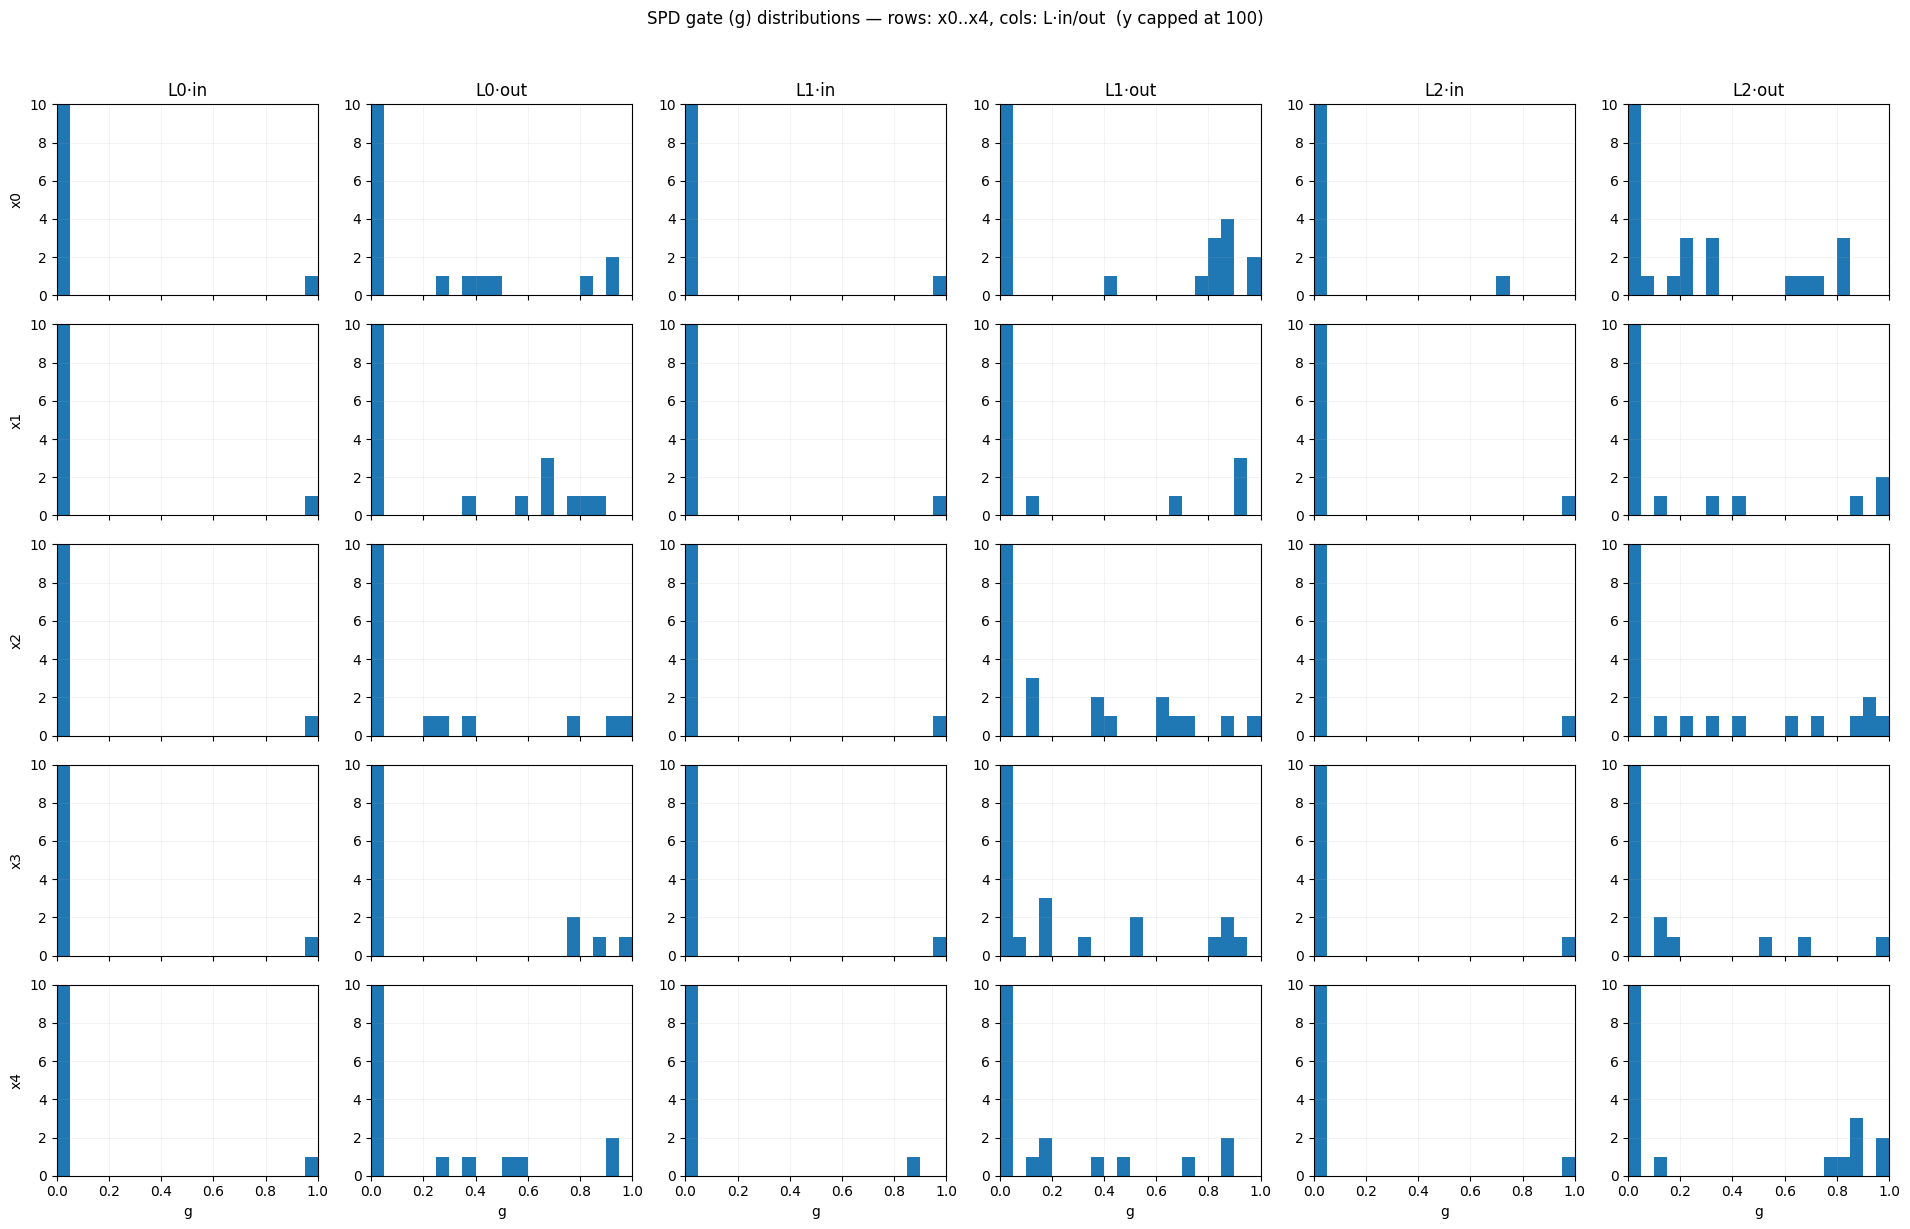

In [19]:
# %%
# Cell 11 (y-capped): g-distribution per input × module, with y-axis capped at 100

import re
import numpy as np
import torch
import matplotlib.pyplot as plt

# Batch of the five diverse inputs (uses x0..x4 created earlier)
X_batch = torch.stack([X_LIST[i] for i in range(5)], dim=0).to(DEVICE)

# Get gates for this batch (module -> (5, C))
GATES = component_activations(
    model=MODEL,
    device=DEVICE,
    batch=X_batch,
    sigmoid_type="hard",
)

# Order modules by layer idx, mlp_in before mlp_out
def _module_order_key(k: str) -> tuple[int, int]:
    m = re.match(r"layers\.(\d+)\.(mlp_in|mlp_out)", k)
    if not m: return (10**6, 0)
    return (int(m.group(1)), 0 if m.group(2) == "mlp_in" else 1)

module_keys = sorted([k for k in GATES.keys() if k.startswith("layers.")], key=_module_order_key)
n_rows, n_cols = X_batch.shape[0], len(module_keys)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.2*n_cols, 2.4*n_rows), sharex=True)
axes = np.array(axes, ndmin=2)  # normalize to 2D

bins = np.linspace(0.0, 1.0, 21)
Y_MAX = 10  # <- cap the y-axis so tails are visible

for col, mod in enumerate(module_keys):
    m = re.match(r"layers\.(\d+)\.(mlp_in|mlp_out)", mod)
    col_title = f"L{int(m.group(1))}·{'in' if m.group(2)=='mlp_in' else 'out'}" if m else mod
    acts = GATES[mod].detach().cpu().numpy()  # (5, C)

    for row in range(n_rows):
        ax = axes[row, col]
        ax.hist(acts[row], bins=bins)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, Y_MAX)  # <-- cap here
        if col == 0: ax.set_ylabel(f"x{row}")
        if row == 0: ax.set_title(col_title)
        if row == n_rows - 1: ax.set_xlabel("g")
        ax.grid(True, alpha=0.2, linewidth=0.5)

fig.suptitle("SPD gate (g) distributions — rows: x0..x4, cols: L·in/out  (y capped at 100)", y=1.02)
plt.tight_layout()
plt.show()



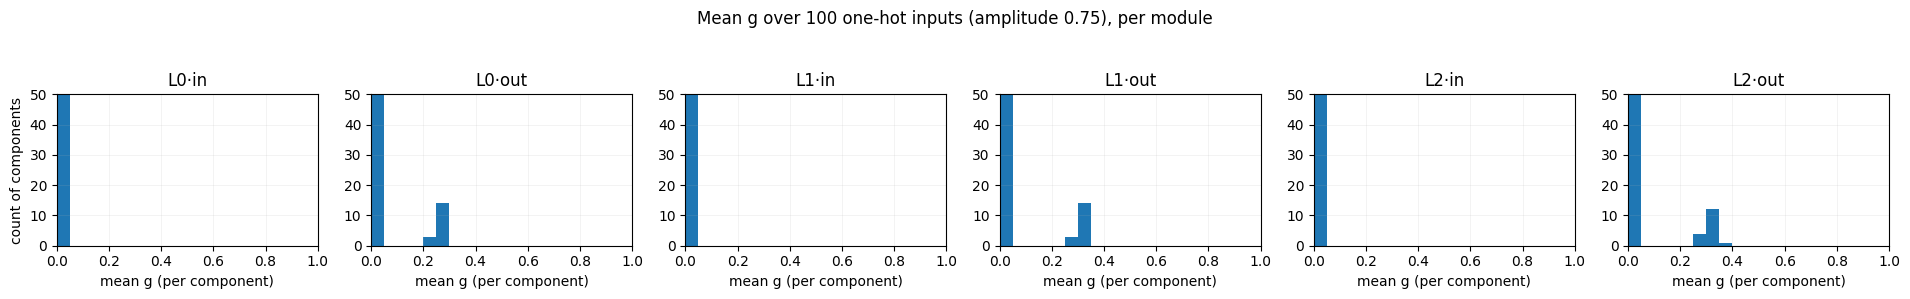

In [20]:
# %%
# Cell: Mean-g plots for 100 one-hot (0.75) inputs

import re, numpy as np, torch
import matplotlib.pyplot as plt

# ----- config -----
USE_FIRST_N = 100
AMPLITUDE   = 0.75
SIGMOID_TYPE = "hard"   # use "normal" for smooth gates
Y_MAX = 50
BINS  = np.linspace(0.0, 1.0, 21)

# ----- build 100 one-hot inputs (0.75) -----
n_features = int(MODEL.patched_model.config.n_features)
N = min(USE_FIRST_N, n_features)

X_hot = torch.zeros(N, n_features, dtype=torch.float32, device=DEVICE)
for i in range(N):
    X_hot[i, i] = AMPLITUDE  # 0.75 at a unique feature index

# ----- get gates and average over the 100 inputs -----
GATES_HOT = component_activations(
    model=MODEL,
    device=DEVICE,
    batch=X_hot,
    sigmoid_type=SIGMOID_TYPE,
)  # dict: module -> (N, C)

def _order_key(k: str) -> tuple[int, int]:
    m = re.match(r"layers\.(\d+)\.(mlp_in|mlp_out)", k)
    if not m: return (10**6, 0)
    return (int(m.group(1)), 0 if m.group(2) == "mlp_in" else 1)

module_keys = sorted([k for k in GATES_HOT.keys() if k.startswith("layers.")], key=_order_key)
mean_g = {k: GATES_HOT[k].mean(dim=0).detach().cpu().numpy() for k in module_keys}

# ----- plot: one row, columns = modules -----
n_cols = len(module_keys)
fig, axes = plt.subplots(1, n_cols, figsize=(3.2*n_cols, 2.8), sharey=False)
if n_cols == 1:
    axes = np.array([axes])

for ci, mod in enumerate(module_keys):
    ax = axes[ci]
    m = re.match(r"layers\.(\d+)\.(mlp_in|mlp_out)", mod)
    title = f"L{int(m.group(1))}·{'in' if m.group(2)=='mlp_in' else 'out'}" if m else mod

    ax.hist(mean_g[mod], bins=BINS)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, Y_MAX)
    ax.set_title(title)
    ax.set_xlabel("mean g (per component)")
    if ci == 0:
        ax.set_ylabel("count of components")
    ax.grid(True, alpha=0.2, linewidth=0.5)

fig.suptitle(f"Mean g over {N} one-hot inputs (amplitude {AMPLITUDE}), per module", y=1.05)
plt.tight_layout()
plt.show()


[dataset-mean g] aggregated 8192 samples over 32 steps (batch=256, sigmoid='hard')


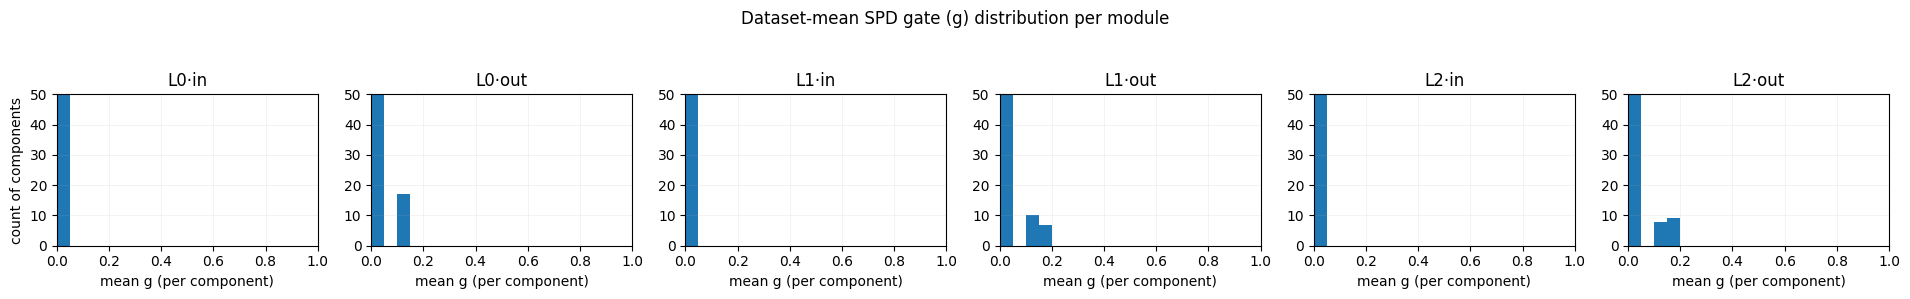

In [21]:
# %%
# Cell 13: Dataset-mean g distributions per module (averaged over a large dataset)

import math, re, torch, numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from spd.experiments.resid_mlp.resid_mlp_dataset import ResidMLPDataset
from spd.utils.data_utils import DatasetGeneratedDataLoader
from spd.utils.general_utils import extract_batch_data

# ----- knobs -----
TOTAL_SAMPLES = 8192    # make it large; adjust as needed
BATCH_SIZE    = 256
SIGMOID_TYPE  = "hard"  # keep consistent with earlier plots; use "normal" for smooth gates
Y_MAX         = 50     # cap histogram y so small mass is visible
BINS          = np.linspace(0.0, 1.0, 21)

# ----- build dataset consistent with training config -----
DATASET_MEAN = ResidMLPDataset(
    n_features=MODEL.patched_model.config.n_features,
    feature_probability=SPD_CONFIG.task_config.feature_probability,
    device=DEVICE,
    calc_labels=False,
    label_type=None,
    act_fn_name=None,
    label_fn_seed=None,
    label_coeffs=None,
    data_generation_type=SPD_CONFIG.task_config.data_generation_type,
)

# prefer the SPD wrapper; fall back to vanilla DataLoader if needed
n_steps = math.ceil(TOTAL_SAMPLES / BATCH_SIZE)
try:
    LOADER_MEAN = DatasetGeneratedDataLoader(
        DATASET_MEAN, batch_size=BATCH_SIZE, shuffle=False
    )
except TypeError:
    from torch.utils.data import DataLoader
    LOADER_MEAN = DataLoader(DATASET_MEAN, batch_size=BATCH_SIZE, shuffle=False)

# ----- accumulate mean gates -----
sum_g: dict[str, torch.Tensor] = OrderedDict()
count = 0

def _order_key(k: str) -> tuple[int, int]:
    m = re.match(r"layers\.(\d+)\.(mlp_in|mlp_out)", k)
    if not m: return (10**6, 0)
    return (int(m.group(1)), 0 if m.group(2) == "mlp_in" else 1)

steps_seen = 0
for batch in LOADER_MEAN:
    if steps_seen >= n_steps:
        break
    x = extract_batch_data(batch).to(DEVICE)
    gates = component_activations(
        model=MODEL, device=DEVICE, batch=x, sigmoid_type=SIGMOID_TYPE
    )  # dict: module -> (batch, C)

    # initialize order on first batch
    if not sum_g:
        for k in sorted(gates.keys(), key=_order_key):
            sum_g[k] = torch.zeros(gates[k].shape[1], device=DEVICE)

    # accumulate
    bs = x.shape[0]
    for k in sum_g.keys():
        sum_g[k] += gates[k].sum(dim=0)
    count += bs
    steps_seen += 1

mean_g = {k: (sum_g[k] / max(count, 1)).detach().cpu().numpy() for k in sum_g.keys()}

print(f"[dataset-mean g] aggregated {count} samples over {steps_seen} steps "
      f"(batch={BATCH_SIZE}, sigmoid='{SIGMOID_TYPE}')")

# ----- plot: one row, columns = modules -----
mods = list(mean_g.keys())
n_cols = len(mods)
fig, axes = plt.subplots(1, n_cols, figsize=(3.2*n_cols, 2.8), sharey=False)

if n_cols == 1:
    axes = np.array([axes])

for ci, mod in enumerate(mods):
    ax = axes[ci]
    # nice title like L0·in / L0·out
    m = re.match(r"layers\.(\d+)\.(mlp_in|mlp_out)", mod)
    title = f"L{int(m.group(1))}·{'in' if m.group(2)=='mlp_in' else 'out'}" if m else mod

    ax.hist(mean_g[mod], bins=BINS)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, Y_MAX)
    ax.set_title(title)
    ax.set_xlabel("mean g (per component)")
    if ci == 0:
        ax.set_ylabel("count of components")
    ax.grid(True, alpha=0.2, linewidth=0.5)

fig.suptitle("Dataset-mean SPD gate (g) distribution per module", y=1.05)
plt.tight_layout()
plt.show()


[dataset-median g] aggregated 8192 samples (batch=256, sigmoid='hard')


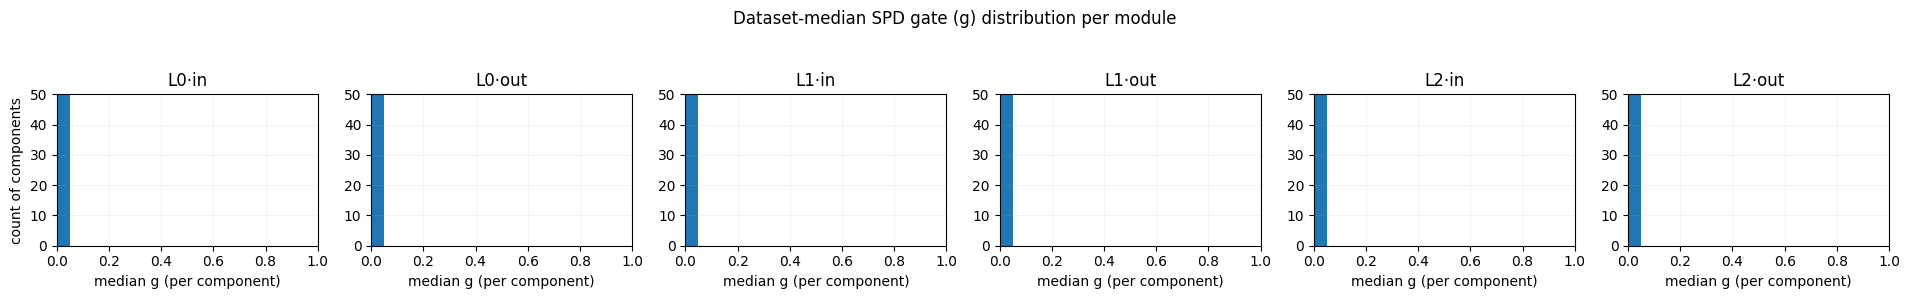

In [22]:
# %%
# Cell: Dataset-median g distributions per module (over a large dataset)

import math, re, torch, numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from spd.experiments.resid_mlp.resid_mlp_dataset import ResidMLPDataset
from spd.utils.data_utils import DatasetGeneratedDataLoader
from spd.utils.general_utils import extract_batch_data

# ----- knobs -----
TOTAL_SAMPLES = 8192    # make it large; adjust as needed
BATCH_SIZE    = 256
SIGMOID_TYPE  = "hard"  # use "normal" for smooth gates
Y_MAX         = 50      # cap histogram y so small mass is visible
BINS          = np.linspace(0.0, 1.0, 21)

# ----- build dataset consistent with training config -----
DATASET_MEDIAN = ResidMLPDataset(
    n_features=MODEL.patched_model.config.n_features,
    feature_probability=SPD_CONFIG.task_config.feature_probability,
    device=DEVICE,
    calc_labels=False,
    label_type=None,
    act_fn_name=None,
    label_fn_seed=None,
    label_coeffs=None,
    data_generation_type=SPD_CONFIG.task_config.data_generation_type,
)

# Prefer the SPD wrapper; if your local version requires n_steps, we’ll just break manually.
try:
    LOADER_MEDIAN = DatasetGeneratedDataLoader(
        DATASET_MEDIAN, batch_size=BATCH_SIZE, shuffle=False
    )
except TypeError:
    from torch.utils.data import DataLoader
    LOADER_MEDIAN = DataLoader(DATASET_MEDIAN, batch_size=BATCH_SIZE, shuffle=False)

def _order_key(k: str) -> tuple[int, int]:
    m = re.match(r"layers\.(\d+)\.(mlp_in|mlp_out)", k)
    if not m: return (10**6, 0)
    return (int(m.group(1)), 0 if m.group(2) == "mlp_in" else 1)

# ----- accumulate gates for median -----
buffers: dict[str, list[torch.Tensor]] = OrderedDict()
module_keys: list[str] | None = None
count = 0

for batch in LOADER_MEDIAN:
    if count >= TOTAL_SAMPLES:
        break
    x = extract_batch_data(batch).to(DEVICE)
    # Truncate last batch if it would exceed TOTAL_SAMPLES
    if count + x.shape[0] > TOTAL_SAMPLES:
        x = x[: TOTAL_SAMPLES - count]

    gates = component_activations(
        model=MODEL, device=DEVICE, batch=x, sigmoid_type=SIGMOID_TYPE
    )  # dict: module -> (batch, C)

    if module_keys is None:
        module_keys = sorted([k for k in gates.keys() if k.startswith("layers.")], key=_order_key)
        for k in module_keys:
            buffers[k] = []

    for k in module_keys:
        # store on CPU to keep GPU mem low
        buffers[k].append(gates[k].detach().cpu())

    count += x.shape[0]

assert module_keys is not None, "No modules found."

median_g = {}
for k in module_keys:
    all_k = torch.cat(buffers[k], dim=0)  # (N_total, C)
    # Use quantile at 0.5 to get the true median for even N
    med_k = torch.quantile(all_k, 0.5, dim=0).numpy()
    median_g[k] = med_k

print(f"[dataset-median g] aggregated {count} samples "
      f"(batch={BATCH_SIZE}, sigmoid='{SIGMOID_TYPE}')")

# ----- plot: one row, columns = modules -----
n_cols = len(module_keys)
fig, axes = plt.subplots(1, n_cols, figsize=(3.2*n_cols, 2.8), sharey=False)
if n_cols == 1:
    axes = np.array([axes])

for ci, mod in enumerate(module_keys):
    ax = axes[ci]
    m = re.match(r"layers\.(\d+)\.(mlp_in|mlp_out)", mod)
    title = f"L{int(m.group(1))}·{'in' if m.group(2)=='mlp_in' else 'out'}" if m else mod

    ax.hist(median_g[mod], bins=BINS)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, Y_MAX)
    ax.set_title(title)
    ax.set_xlabel("median g (per component)")
    if ci == 0:
        ax.set_ylabel("count of components")
    ax.grid(True, alpha=0.2, linewidth=0.5)

fig.suptitle("Dataset-median SPD gate (g) distribution per module", y=1.05)
plt.tight_layout()
plt.show()


In [23]:
# %%
# Cell 12: Top-K components by g for each input (x0..x4) and each layer
import re
import torch
from collections import OrderedDict

# --- adjust K here (or set TOPK in a previous cell) ---
TOPK = int(globals().get("TOPK", 10))

# Build/ensure gates for the five inputs
if "GATES" not in globals():
    assert "X_LIST" in globals(), "Need X_LIST (x0..x9) defined."
    X_batch = torch.stack([X_LIST[i] for i in range(5)], dim=0).to(DEVICE)
    GATES = component_activations(
        model=MODEL,
        device=DEVICE,
        batch=X_batch,
        sigmoid_type="hard",
    )

# Order modules as L0·in, L0·out, L1·in, L1·out, ...
def _module_order_key(k: str) -> tuple[int, int]:
    m = re.match(r"layers\.(\d+)\.(mlp_in|mlp_out)", k)
    if not m: return (10**6, 0)
    return (int(m.group(1)), 0 if m.group(2) == "mlp_in" else 1)

module_keys = sorted(
    [k for k in GATES.keys() if k.startswith("layers.")],
    key=_module_order_key
)

# Pretty name for column headers
def _mod_short(mod: str) -> str:
    m = re.match(r"layers\.(\d+)\.(mlp_in|mlp_out)", mod)
    return f"L{int(m.group(1))}·{'in' if m.group(2)=='mlp_in' else 'out'}" if m else mod

# Print top-K per input and per module
for row in range(5):  # x0..x4
    print(f"\n[x{row}] top-{TOPK} components by g")
    for mod in module_keys:
        g_vec = GATES[mod][row]  # shape (C,)
        k = min(TOPK, g_vec.numel())
        vals, idxs = torch.topk(g_vec, k=k)
        tops = ", ".join(
            [f"{mod}:{int(i)} (g={float(v):.3f})" for v, i in zip(vals.tolist(), idxs.tolist())]
        )
        print(f"  {_mod_short(mod)}: {tops}")



[x0] top-10 components by g
  L0·in: layers.0.mlp_in:470 (g=1.000), layers.0.mlp_in:491 (g=0.012), layers.0.mlp_in:414 (g=0.010), layers.0.mlp_in:465 (g=0.009), layers.0.mlp_in:307 (g=0.007), layers.0.mlp_in:486 (g=0.007), layers.0.mlp_in:7 (g=0.007), layers.0.mlp_in:455 (g=0.006), layers.0.mlp_in:199 (g=0.005), layers.0.mlp_in:155 (g=0.004)
  L0·out: layers.0.mlp_out:305 (g=0.928), layers.0.mlp_out:28 (g=0.923), layers.0.mlp_out:423 (g=0.815), layers.0.mlp_out:454 (g=0.466), layers.0.mlp_out:248 (g=0.404), layers.0.mlp_out:95 (g=0.381), layers.0.mlp_out:224 (g=0.275), layers.0.mlp_out:7 (g=0.000), layers.0.mlp_out:8 (g=0.000), layers.0.mlp_out:9 (g=0.000)
  L1·in: layers.1.mlp_in:57 (g=1.000), layers.1.mlp_in:237 (g=0.014), layers.1.mlp_in:400 (g=0.013), layers.1.mlp_in:399 (g=0.010), layers.1.mlp_in:401 (g=0.009), layers.1.mlp_in:30 (g=0.008), layers.1.mlp_in:325 (g=0.008), layers.1.mlp_in:291 (g=0.007), layers.1.mlp_in:163 (g=0.007), layers.1.mlp_in:162 (g=0.007)
  L1·out: layers.1

# Neuron Contribution Plots

In [24]:
# %%
# Cell: Compute neuron & subcomponent contributions (Eq. 11 and 12) for a chosen layer

import torch
import re

# ----- settings -----
LAYER_IDX   = 0          # which ResidMLP layer to analyze
FEATURE_IDS = list(range(10))  # first 10 input features i ∈ {0..9}
AMPLITUDE   = 0.75       # one-hot magnitude for x_i
COMP_SHOW   = 50         # how many subcomponents to include in bottom plot (first 50)

# ----- fetch weights from the (patched) model -----
patched = getattr(MODEL, "patched_model", MODEL)
sd = patched.state_dict()

W_E  = sd["W_E"]                         # (n_features, d_resid) : r0 = X @ W_E
W_U  = sd["W_U"]                         # (d_resid, n_features): y = r @ W_U
W_in  = sd[f"layers.{LAYER_IDX}.mlp_in.original.weight"]   # (d_mlp, d_resid)
W_out = sd[f"layers.{LAYER_IDX}.mlp_out.original.weight"]  # (d_resid, d_mlp)

# SPD components (rank-1 atoms) for this layer
U_in  = sd[f"layers.{LAYER_IDX}.mlp_in.components.U"]      # (C, d_mlp)
V_in  = sd[f"layers.{LAYER_IDX}.mlp_in.components.V"]      # (d_resid, C)
U_out = sd[f"layers.{LAYER_IDX}.mlp_out.components.U"]     # (C, d_resid)
V_out = sd[f"layers.{LAYER_IDX}.mlp_out.components.V"]     # (d_mlp, C)

device = W_E.device

# ----- vectorized Eq. 11 (model, per neuron) -----
# downstream_i = (W_U[:, i]^T @ W_out) ∈ R^{d_mlp}
# upstream_i   = (W_in @ W_E[i, :]^T) ∈ R^{d_mlp}
# contribution_model(i) = downstream_i ⊙ upstream_i
with torch.no_grad():
    idx = torch.tensor(FEATURE_IDS, device=device, dtype=torch.long)

    WU_sub = W_U[:, idx]               # (d_resid, n_i)
    WE_sub = W_E[idx, :]               # (n_i, d_resid)

    # downstream: (n_i × d_mlp)
    downstream_full = WU_sub.T @ W_out           # (n_i, d_mlp)
    # upstream: (d_mlp × n_i) -> (n_i, d_mlp)
    upstream_full   = (W_in @ WE_sub.T).T        # (n_i, d_mlp)

    # amplitude only affects upstream path (input → residual)
    CONTRIB_MODEL = downstream_full * (AMPLITUDE * upstream_full)  # (n_i, d_mlp)

# ----- vectorized Eq. 12 (per subcomponent m, then take max over neurons) -----
# For each component m:
#   downstream_m(i, :) = v_out_m * (W_U[:, i] · u_out_m)       ∈ R^{d_mlp}
#   upstream_m(i, :)   = u_in_m  * (W_E[i, :] · v_in_m)        ∈ R^{d_mlp}
#   contrib_m(i, :)    = downstream_m ⊙ (AMPLITUDE * upstream_m)
# We summarize each (i, m) with max over neurons k to get a scalar like the paper’s bottom panel.

with torch.no_grad():
    n_i   = len(FEATURE_IDS)
    C_in  = U_in.shape[0]
    C_out = U_out.shape[0]
    assert C_in == C_out, "Expected same #components for in/out"
    C = C_in

    # precompute projections shared across m
    # (n_i, d_resid)
    WU_rows  = WU_sub.T.contiguous()   # rename for clarity
    WE_rows  = WE_sub.contiguous()

    # allocate (n_i, min(C, COMP_SHOW))
    M = min(C, COMP_SHOW)
    CONTRIB_SUBCOMP_MAX = torch.empty(n_i, M, device="cpu")
    # (optional) also keep which neuron maximized the contribution
    ARGMAX_NEURON = torch.empty(n_i, M, dtype=torch.long, device="cpu")

    for m in range(M):
        u_out_m = U_out[m]        # (d_resid,)
        v_out_m = V_out[:, m]     # (d_mlp,)
        u_in_m  = U_in[m]         # (d_mlp,)
        v_in_m  = V_in[:, m]      # (d_resid,)

        # scalars per i
        s_down = (WU_rows @ u_out_m)            # (n_i,)
        s_up   = (WE_rows @ v_in_m)             # (n_i,)

        # broadcast to (n_i, d_mlp)
        downstream_m = s_down.unsqueeze(1) * v_out_m.unsqueeze(0)      # (n_i, d_mlp)
        upstream_m   = s_up.unsqueeze(1)   * u_in_m.unsqueeze(0)       # (n_i, d_mlp)

        contrib_m = downstream_m * (AMPLITUDE * upstream_m)            # (n_i, d_mlp)
        # summarize: max over neurons
        vals, argk = contrib_m.max(dim=1)                               # both (n_i,)
        CONTRIB_SUBCOMP_MAX[:, m] = vals.cpu()
        ARGMAX_NEURON[:, m]       = argk.cpu()

# Convenience: also store the top neuron per input for the full model (Eq. 11)
with torch.no_grad():
    TOP_NEURON_VALS, TOP_NEURON_IDX = CONTRIB_MODEL.max(dim=1)  # (n_i,)
    TOP_NEURON_VALS = TOP_NEURON_VALS.cpu()
    TOP_NEURON_IDX  = TOP_NEURON_IDX.cpu()

print("[contrib] layer", LAYER_IDX,
      "| d_mlp =", W_in.shape[0],
      "| #components =", U_in.shape[0],
      "| features =", FEATURE_IDS[:5], "...")


[contrib] layer 0 | d_mlp = 17 | #components = 500 | features = [0, 1, 2, 3, 4] ...


In [25]:
# %%
# Cell: Print top activating neurons (Eq.11) and subcomponents (Eq.12-style) per input

import torch
import re
from typing import List, Tuple

# -------- knobs --------
LAYER_IDX     = 0            # which ResidMLP layer to analyze
FEATURE_IDS   = list(range(10))  # inputs i = 0..9
AMPLITUDE     = 0.75         # one-hot magnitude
TOPK_NEURONS  = 10
TOPK_SUBCOMPS = 10

# -------- fetch weights --------
patched = getattr(MODEL, "patched_model", MODEL)
sd = patched.state_dict()
device = sd["W_E"].device

W_E   = sd["W_E"]                                      # (n_features, d_resid)
W_U   = sd["W_U"]                                      # (d_resid, n_features)
W_in  = sd[f"layers.{LAYER_IDX}.mlp_in.original.weight"]   # (d_mlp, d_resid)
W_out = sd[f"layers.{LAYER_IDX}.mlp_out.original.weight"]  # (d_resid, d_mlp)

# SPD atoms (rank-1)
U_in  = sd[f"layers.{LAYER_IDX}.mlp_in.components.U"]      # (C, d_mlp)
V_in  = sd[f"layers.{LAYER_IDX}.mlp_in.components.V"]      # (d_resid, C)
U_out = sd[f"layers.{LAYER_IDX}.mlp_out.components.U"]     # (C, d_resid)
V_out = sd[f"layers.{LAYER_IDX}.mlp_out.components.V"]     # (d_mlp, C)
C_in, d_mlp = U_in.shape
C_out, d_resid_check = U_out.shape
assert C_in == C_out, "Expected same number of atoms for mlp_in and mlp_out"
C = C_in

# -------- Eq. 11: full model contributions per input & neuron --------
with torch.no_grad():
    idx = torch.tensor(FEATURE_IDS, device=device, dtype=torch.long)  # (n_i,)
    WE_sub = W_E[idx, :]            # (n_i, d_resid)
    WU_sub = W_U[:, idx]            # (d_resid, n_i)

    # downstream: (n_i, d_mlp) via (W_U[:,i]^T @ W_out)
    downstream_full = (WU_sub.T @ W_out)      # (n_i, d_mlp)
    # upstream: (n_i, d_mlp) via (W_in @ W_E[i,:]^T)
    upstream_full   = (W_in @ WE_sub.T).T     # (n_i, d_mlp)

    CONTRIB_MODEL = downstream_full * (AMPLITUDE * upstream_full)  # (n_i, d_mlp)

# -------- Eq. 12-style: per-subcomponent contributions --------
# For each atom m:
#   downstream_m(i,k) = (W_U[:,i]·U_out[m]) * V_out[k,m]
#   upstream_m(i,k)   = (W_E[i,:]·V_in[:,m]) * U_in[m,k]
#   contrib_m(i,k)    = downstream_m * (AMPLITUDE * upstream_m)
# Score per (i,m): max_k contrib_m(i,k)
with torch.no_grad():
    n_i = len(FEATURE_IDS)
    WE_rows = WE_sub.contiguous()   # (n_i, d_resid)
    WU_rows = WU_sub.T.contiguous() # (n_i, d_resid)

    # Precompute projections for all atoms at once
    # s_down(i,m) = WU_rows(i,:) · U_out[m,:]^T
    s_down = WU_rows @ U_out.T            # (n_i, C)
    # s_up(i,m)   = WE_rows(i,:) · V_in[:,m]
    s_up   = WE_rows @ V_in               # (n_i, C)

    # Broadcast to neurons via V_out and U_in
    # downstream_m(i,k) = s_down(i,m) * V_out[k,m]
    # upstream_m(i,k)   = s_up(i,m)   * U_in[m,k]
    # We need per-neuron max, so compute contrib and reduce over k
    # Shapes for broadcasting: add singleton dims
    s_down_b = s_down.unsqueeze(2)              # (n_i, C, 1)
    s_up_b   = s_up.unsqueeze(2)                # (n_i, C, 1)
    Vout_b   = V_out.T.unsqueeze(0)             # (1, C, d_mlp)  (C,d_mlp)->(1,C,d_mlp)
    Uin_b    = U_in.unsqueeze(0)                # (1, C, d_mlp)

    contrib_all = (s_down_b * Vout_b) * (AMPLITUDE * (s_up_b * Uin_b))  # (n_i, C, d_mlp)
    vals, argk = contrib_all.max(dim=2)         # vals: (n_i, C), argk: (n_i, C)

# -------- printing --------
def _topk_tensor_row(t: torch.Tensor, k: int) -> List[Tuple[int, float]]:
    """Return top-k (index, value) by absolute value from a 1D tensor."""
    k = min(k, t.numel())
    vals, idxs = torch.topk(t.abs(), k=k)
    out = []
    for v_abs, j in zip(vals.tolist(), idxs.tolist()):
        v = float(t[j].item())
        out.append((int(j), v))
    return out

n_i = len(FEATURE_IDS)
print(f"[Layer {LAYER_IDX}] Top activations per input (amplitude={AMPLITUDE})")

for i_pos, i_feat in enumerate(FEATURE_IDS):
    print(f"\nInput feature i={i_feat}")

    # Top neurons (Eq. 11)
    row = CONTRIB_MODEL[i_pos]  # (d_mlp,)
    top_neurons = _topk_tensor_row(row, TOPK_NEURONS)
    line = ", ".join([f"neuron {k}: {v:+.4f}" for k, v in top_neurons])
    print(f"  Eq.11 — top {len(top_neurons)} neurons: {line}")

    # Top subcomponents (by max over neurons), also show which neuron achieved the max
    row_vals = vals[i_pos]          # (C,)
    row_argk = argk[i_pos]          # (C,)
    # sort by absolute value
    k = min(TOPK_SUBCOMPS, row_vals.numel())
    srt = torch.argsort(row_vals.abs(), descending=True)[:k]
    tops = []
    for m in srt.tolist():
        v = float(row_vals[m].item())
        nk = int(row_argk[m].item())
        tops.append((m, nk, v))
    line2 = ", ".join([f"m {m} (neuron {nk}): {v:+.4f}" for (m, nk, v) in tops])
    print(f"  Eq.12-style — top {len(tops)} subcomponents (max over neurons): {line2}")



[Layer 0] Top activations per input (amplitude=0.75)

Input feature i=0
  Eq.11 — top 10 neurons: neuron 4: +0.0455, neuron 16: +0.0286, neuron 10: +0.0093, neuron 11: +0.0033, neuron 12: +0.0029, neuron 0: +0.0025, neuron 8: +0.0022, neuron 13: +0.0022, neuron 15: +0.0017, neuron 9: -0.0015
  Eq.12-style — top 10 subcomponents (max over neurons): m 470 (neuron 4): +0.0000, m 137 (neuron 13): +0.0000, m 95 (neuron 9): +0.0000, m 305 (neuron 4): +0.0000, m 486 (neuron 5): +0.0000, m 224 (neuron 6): +0.0000, m 414 (neuron 5): +0.0000, m 455 (neuron 5): +0.0000, m 439 (neuron 6): +0.0000, m 199 (neuron 13): +0.0000

Input feature i=1
  Eq.11 — top 10 neurons: neuron 14: +0.0139, neuron 4: +0.0127, neuron 8: +0.0031, neuron 16: +0.0030, neuron 11: +0.0028, neuron 3: +0.0020, neuron 13: +0.0016, neuron 2: +0.0011, neuron 0: +0.0011, neuron 5: -0.0010
  Eq.12-style — top 10 subcomponents (max over neurons): m 26 (neuron 3): +0.0000, m 486 (neuron 1): +0.0000, m 137 (neuron 13): +0.0000, m 45

# Similarity Measures

In [26]:
# %%
# Cell: similarity measures (pairwise + matrix forms)

from typing import Dict, Tuple
import torch

EPS = 1e-8

# ---------------------------
# Helpers
# ---------------------------

def _as1d(x: torch.Tensor) -> torch.Tensor:
    if not isinstance(x, torch.Tensor):
        x = torch.as_tensor(x)
    return x.reshape(-1)

# ---------------------------
# 1) Directional similarity on residual-space vectors
#    s_dir(i,j) = cos(residual_vec[i], residual_vec[j])
# ---------------------------

def s_dir_from_vectors(v1: torch.Tensor, v2: torch.Tensor) -> float:
    """Cosine similarity between two 1D vectors."""
    v1 = _as1d(v1); v2 = _as1d(v2)
    num = torch.dot(v1, v2)
    den = (v1.norm() * v2.norm()) + EPS
    return float(num / den)

def s_dir(label_i: str, label_j: str, residual_vecs: Dict[str, torch.Tensor]) -> float:
    """Cosine similarity between components via residual_vecs[label]."""
    return s_dir_from_vectors(residual_vecs[label_i], residual_vecs[label_j])

def cosine_matrix(X: torch.Tensor) -> torch.Tensor:
    """Row-wise cosine similarity matrix for X ∈ R^{C×d}. Returns (C×C)."""
    X = X if isinstance(X, torch.Tensor) else torch.as_tensor(X)
    Xn = X / (X.norm(dim=1, keepdim=True) + EPS)
    return Xn @ Xn.T

# ---------------------------
# 2) Activation correlation (Pearson) on gate profiles
#    corr(i,j) = corr(A[:,i], A[:,j])
# ---------------------------

def activation_correlation_cols(A: torch.Tensor, i: int, j: int) -> float:
    """Pearson correlation between columns i and j of A (N×C)."""
    A = A if isinstance(A, torch.Tensor) else torch.as_tensor(A)
    xi = A[:, i]; yi = A[:, j]
    x0 = xi - xi.mean(); y0 = yi - yi.mean()
    denom = (x0.std(unbiased=True) * y0.std(unbiased=True)) + EPS
    return float((x0 @ y0) / ((A.shape[0] - 1) * denom))

def activation_correlation_labels(A: torch.Tensor, label_to_col: Dict[str, int],
                                  label_i: str, label_j: str) -> float:
    return activation_correlation_cols(A, label_to_col[label_i], label_to_col[label_j])

def corr_matrix(A: torch.Tensor) -> torch.Tensor:
    """Pearson correlation matrix over columns of A (N×C) → (C×C)."""
    A = A if isinstance(A, torch.Tensor) else torch.as_tensor(A)
    X = A - A.mean(dim=0, keepdim=True)
    std = A.std(dim=0, unbiased=True, keepdim=True) + EPS
    Xn = X / std
    return (Xn.T @ Xn) / (A.shape[0] - 1)

# ---------------------------
# 3) Co-activation expectation
#    E[g_i g_j] over dataset
# ---------------------------

def coactivation_expectation_cols(A: torch.Tensor, i: int, j: int) -> float:
    """E[g_i g_j] where A[:,i] and A[:,j] are gate columns."""
    A = A if isinstance(A, torch.Tensor) else torch.as_tensor(A)
    return float((A[:, i] * A[:, j]).mean())

def coactivation_expectation_labels(A: torch.Tensor, label_to_col: Dict[str, int],
                                    label_i: str, label_j: str) -> float:
    return coactivation_expectation_cols(A, label_to_col[label_i], label_to_col[label_j])

def coactivation_matrix(A: torch.Tensor) -> torch.Tensor:
    """E[g g^T] over samples: (A^T A)/N  (C×C)."""
    A = A if isinstance(A, torch.Tensor) else torch.as_tensor(A)
    return (A.T @ A) / A.shape[0]

# ---------------------------
# 4) Weighted similarity (for graph edges)
# ---------------------------

def weighted_similarity(
    s_dir_val: float,
    s_corr_val: float,
    s_coact_val: float,
    w_dir: float = 0.5,
    w_corr: float = 0.3,
    w_coact: float = 0.2,
) -> float:
    """Combine three sims into one scalar. Use normalized inputs if desired."""
    return float(w_dir * s_dir_val + w_corr * s_corr_val + w_coact * s_coact_val)


In [27]:
# %%
# Cell: Rank component pairs by Pearson correlation of gate profiles

import math, re, torch
from typing import Dict, List, Tuple
import numpy as np

from spd.experiments.resid_mlp.resid_mlp_dataset import ResidMLPDataset
from spd.utils.data_utils import DatasetGeneratedDataLoader
from spd.utils.general_utils import extract_batch_data
from spd.clustering.activations import component_activations, process_activations

# ---- knobs ----
TOPK = 300                 # how many top pairs to print
TOTAL_SAMPLES = 4096      # dataset size for gate profiles if we need to recompute
BATCH_SIZE    = 256
SIGMOID_TYPE  = "hard"
FILTER_DEAD_THRESHOLD = 0.1
EPS = 1e-8

# ---- acquire activations matrix A (N × C_alive) and labels (length C_alive) ----
if "PA" in globals() and hasattr(PA, "activations") and hasattr(PA, "labels"):
    A = PA.activations
    labels = PA.labels
    print(f"[reuse] Using existing activations: A={tuple(A.shape)} components={len(labels)}")
else:
    print("[compute] Building dataset and computing gate profiles...")
    # Dataset matching training params
    DATASET = ResidMLPDataset(
        n_features=MODEL.patched_model.config.n_features,
        feature_probability=SPD_CONFIG.task_config.feature_probability,
        device=DEVICE,
        calc_labels=False,
        label_type=None,
        act_fn_name=None,
        label_fn_seed=None,
        label_coeffs=None,
        data_generation_type=SPD_CONFIG.task_config.data_generation_type,
    )
    LOADER = DatasetGeneratedDataLoader(DATASET, batch_size=BATCH_SIZE, shuffle=False)

    # Accumulate gates up to TOTAL_SAMPLES
    gates_accum: Dict[str, list[torch.Tensor]] = {}
    seen = 0
    for batch in LOADER:
        if seen >= TOTAL_SAMPLES:
            break
        x = extract_batch_data(batch).to(DEVICE)
        take = min(x.shape[0], TOTAL_SAMPLES - seen)
        g = component_activations(MODEL, DEVICE, batch=x[:take], sigmoid_type=SIGMOID_TYPE)
        if not gates_accum:
            for k in g.keys():
                gates_accum[k] = []
        for k in gates_accum.keys():
            gates_accum[k].append(g[k].detach())
        seen += take

    COMP_ACTS = {k: torch.cat(v, dim=0) for k, v in gates_accum.items()}  # module -> (N,C)
    PA = process_activations(
        COMP_ACTS,
        filter_dead_threshold=FILTER_DEAD_THRESHOLD,
        sort_components=False,
    )
    A = PA.activations
    labels = PA.labels
    print(f"[compute] A={tuple(A.shape)} components={len(labels)}")

# ---- Pearson correlation matrix over columns of A ----
def corr_matrix(A: torch.Tensor) -> torch.Tensor:
    X = A - A.mean(dim=0, keepdim=True)
    std = A.std(dim=0, unbiased=True, keepdim=True)
    std = torch.where(std > 0, std, torch.full_like(std, EPS))
    Xn = X / std
    return (Xn.T @ Xn) / (A.shape[0] - 1 + EPS)

CORR = corr_matrix(A).detach().cpu()  # (C,C)
C = CORR.shape[0]

# ---- rank upper-triangular pairs by correlation ----
tri = torch.triu_indices(C, C, offset=1)
vals = CORR[tri[0], tri[1]]
topv, topi = torch.topk(vals, k=min(TOPK, vals.numel()))

print(f"\n[top {len(topv)} pairs by Pearson corr]  (components alive: {C})")
for v, i in zip(topv.tolist(), topi.tolist()):
    a = tri[0, i].item()
    b = tri[1, i].item()
    print(f"  corr={v:.3f}   {labels[a]}  —  {labels[b]}")


[compute] Building dataset and computing gate profiles...
[compute] A=(4096, 380) components=380

[top 300 pairs by Pearson corr]  (components alive: 380)
  corr=0.999   layers.1.mlp_in:136  —  layers.2.mlp_in:349
  corr=0.999   layers.0.mlp_in:169  —  layers.1.mlp_in:66
  corr=0.999   layers.0.mlp_in:123  —  layers.1.mlp_in:424
  corr=0.999   layers.0.mlp_in:36  —  layers.1.mlp_in:384
  corr=0.999   layers.0.mlp_in:233  —  layers.1.mlp_in:209
  corr=0.999   layers.1.mlp_in:409  —  layers.2.mlp_in:367
  corr=0.999   layers.0.mlp_in:424  —  layers.2.mlp_in:414
  corr=0.999   layers.0.mlp_in:450  —  layers.2.mlp_in:358
  corr=0.999   layers.0.mlp_in:199  —  layers.2.mlp_in:85
  corr=0.998   layers.0.mlp_in:144  —  layers.2.mlp_in:0
  corr=0.998   layers.1.mlp_in:394  —  layers.2.mlp_in:145
  corr=0.998   layers.0.mlp_in:421  —  layers.1.mlp_in:250
  corr=0.998   layers.1.mlp_in:344  —  layers.2.mlp_in:347
  corr=0.998   layers.1.mlp_in:253  —  layers.2.mlp_in:46
  corr=0.998   layers.0.m

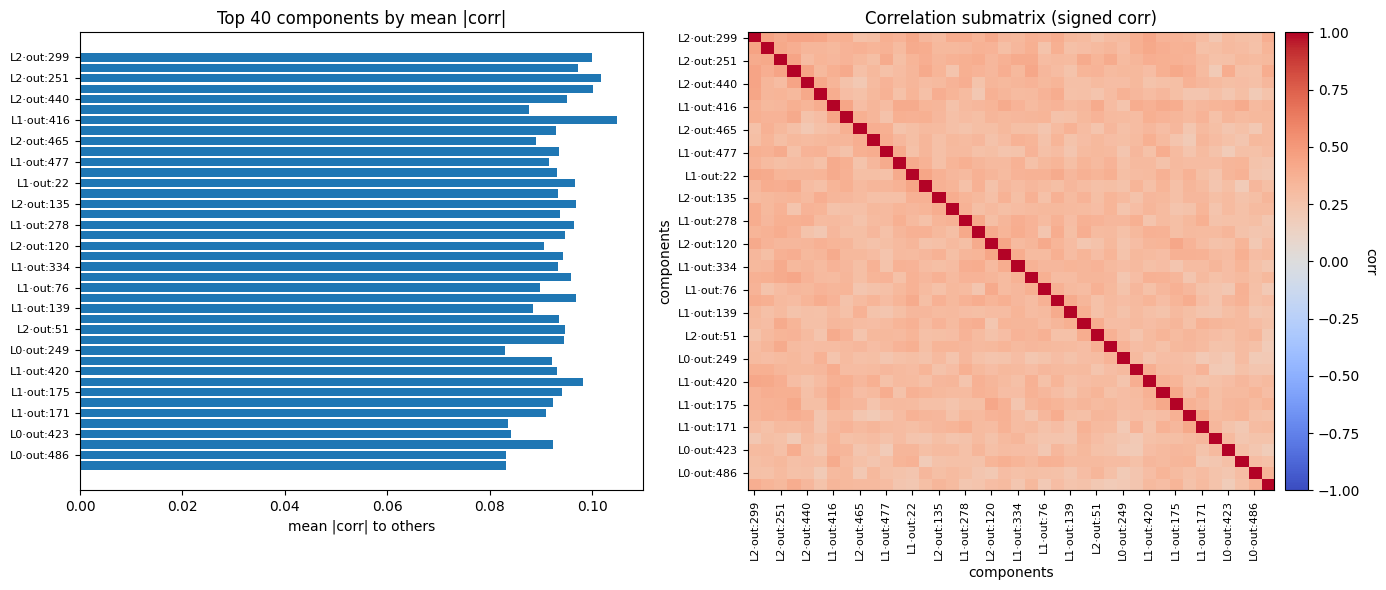

In [28]:
# %%
# Cell: Visual correlation view — top-M components by mean |corr| with a reordered heatmap

import re
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- knobs ---
TOP_COMPONENTS = 40     # how many components to visualize
USE_ABS_FOR_HEATMAP = False  # set True to plot |corr| instead of signed corr

# Expect CORR (C×C) and labels already from the previous cell; else derive from A
if "CORR" not in globals() or "labels" not in globals():
    assert "A" in globals() and "PA" in globals(), "Need A and PA.labels in scope."
    labels = PA.labels
    def _corr_matrix(A: torch.Tensor) -> torch.Tensor:
        X = A - A.mean(dim=0, keepdim=True)
        std = A.std(dim=0, unbiased=True, keepdim=True)
        std = torch.where(std > 0, std, torch.ones_like(std))
        Xn = X / std
        return (Xn.T @ Xn) / (A.shape[0] - 1)
    CORR = _corr_matrix(A).detach().cpu()

C = CORR.shape[0]
abs_corr = CORR.abs()
mean_abs = (abs_corr.sum(dim=1) - abs_corr.diagonal()) / (C - 1)

# pick top-M by mean |corr|
k = min(TOP_COMPONENTS, C)
top_idx = torch.topk(mean_abs, k=k).indices

# greedy reorder within the selected set to make blocks pop in the heatmap
sub = CORR[top_idx][:, top_idx].clone()
sub_abs = sub.abs()
n = sub.shape[0]
avg_sim = sub_abs.mean(dim=1)
start = int(torch.argmax(avg_sim))
order = [start]
remaining = set(range(n))
remaining.remove(start)
curr = start
while remaining:
    nxt = max(remaining, key=lambda j: float(sub_abs[curr, j]))
    order.append(nxt)
    remaining.remove(nxt)
    curr = nxt
perm = torch.tensor(order, dtype=torch.long)
sub_re = sub[perm][:, perm]

lab_sub = [labels[i] for i in top_idx[perm].tolist()]

def _short(l: str) -> str:
    m = re.match(r"layers\.(\d+)\.(mlp_in|mlp_out):(\d+)", l)
    return f"L{m.group(1)}·{'in' if m.group(2)=='mlp_in' else 'out'}:{m.group(3)}" if m else l

tick_labels = [_short(l) for l in lab_sub]

# plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={"width_ratios":[1,1]})

# left: barh of mean |corr|
ax = axs[0]
ax.barh(range(k), mean_abs[top_idx[perm]].numpy())
ax.set_yticks(range(k))
# show every 2nd label if many
step = 2 if k > 30 else 1
yticks = list(range(0, k, step))
ax.set_yticks(yticks)
ax.set_yticklabels([tick_labels[i] for i in yticks], fontsize=8)
ax.invert_yaxis()
ax.set_xlabel("mean |corr| to others")
ax.set_title(f"Top {k} components by mean |corr|")

# right: heatmap
ax2 = axs[1]
mat = sub_re.abs().numpy() if USE_ABS_FOR_HEATMAP else sub_re.numpy()
im = ax2.imshow(mat, vmin=(-1 if not USE_ABS_FOR_HEATMAP else 0), vmax=1, cmap="coolwarm", aspect="auto", interpolation="nearest")
ax2.set_title(f"Correlation submatrix ({'|corr|' if USE_ABS_FOR_HEATMAP else 'signed corr'})")
ax2.set_xlabel("components")
ax2.set_ylabel("components")

# sparse ticks to keep legible
ax2.set_xticks(yticks)
ax2.set_xticklabels([tick_labels[i] for i in yticks], rotation=90, fontsize=8)
ax2.set_yticks(yticks)
ax2.set_yticklabels([tick_labels[i] for i in yticks], fontsize=8)

cbar = fig.colorbar(im, ax=ax2, fraction=0.046, pad=0.02)
cbar.ax.set_ylabel("corr", rotation=270, labelpad=12)

plt.tight_layout()
plt.show()


[counts] original=3000  alive=380  dead=2620


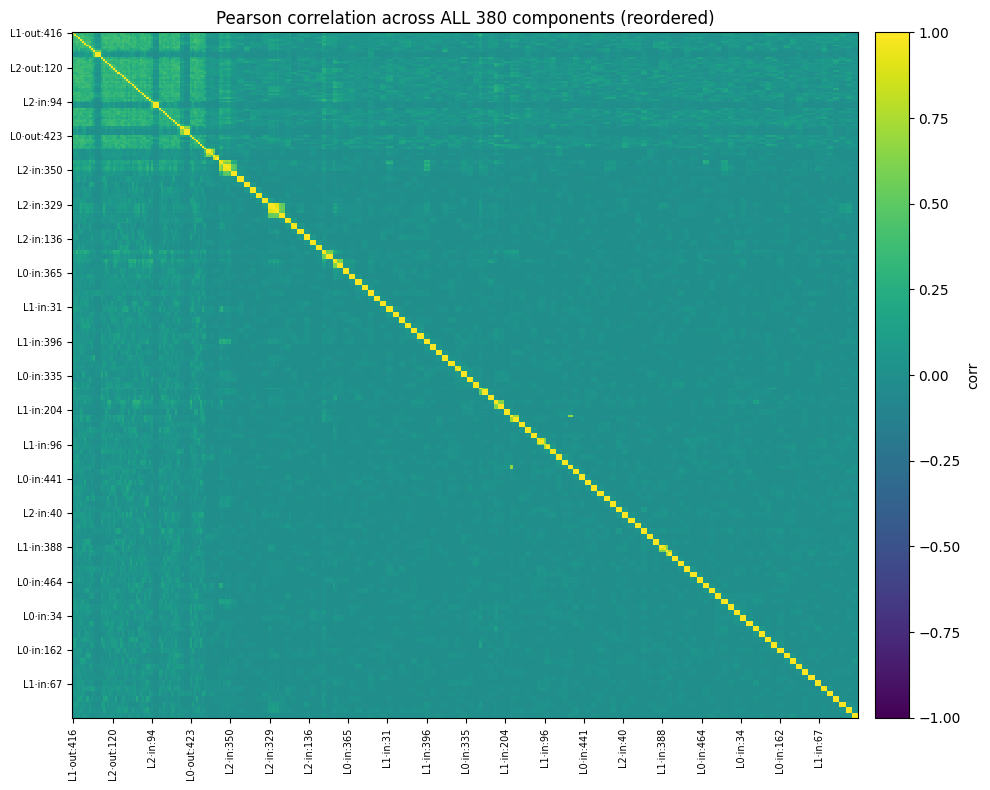

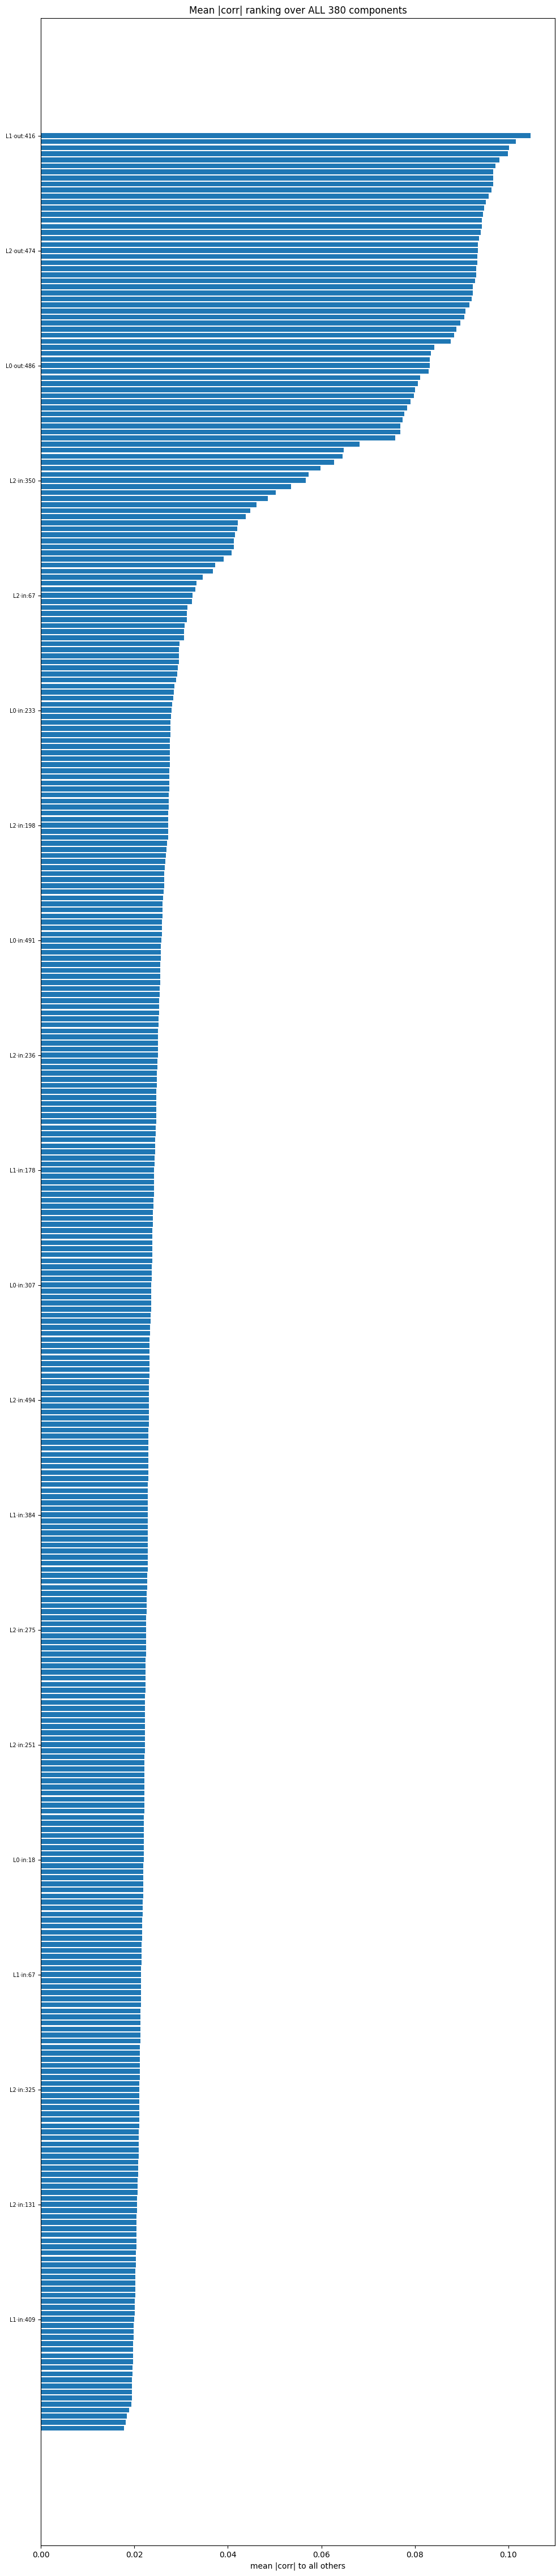

In [29]:
# %%
# Cell: Full correlation graphs for ALL alive components

import re, torch, numpy as np, matplotlib.pyplot as plt

assert "PA" in globals(), "Need PA (from process_activations) in scope."
A = PA.activations      # (N, C_alive)
labels = PA.labels      # length C_alive
C_alive = len(labels)

print(f"[counts] original={PA.n_components_original}  alive={PA.n_components_alive}  dead={PA.n_components_dead}")

# --- Pearson correlation over columns of A ---
def corr_matrix(A: torch.Tensor) -> torch.Tensor:
    X = A - A.mean(dim=0, keepdim=True)
    std = A.std(dim=0, unbiased=True, keepdim=True)
    std = torch.where(std > 0, std, torch.ones_like(std))
    Xn = X / std
    return (Xn.T @ Xn) / (A.shape[0] - 1)

CORR = corr_matrix(A).detach().cpu()  # (C, C)

# --- greedy reordering to make blocks pop ---
sub_abs = CORR.abs()
n = CORR.shape[0]
avg_sim = sub_abs.mean(dim=1)
start = int(torch.argmax(avg_sim))
order = [start]
remaining = set(range(n))
remaining.remove(start)
curr = start
while remaining:
    nxt = max(remaining, key=lambda j: float(sub_abs[curr, j]))
    order.append(nxt)
    remaining.remove(nxt)
    curr = nxt
perm = torch.tensor(order, dtype=torch.long)

CORR_re = CORR[perm][:, perm]
lab_re  = [labels[i] for i in perm.tolist()]

def _short(l: str) -> str:
    m = re.match(r"layers\.(\d+)\.(mlp_in|mlp_out):(\d+)", l)
    return f"L{m.group(1)}·{'in' if m.group(2)=='mlp_in' else 'out'}:{m.group(3)}" if m else l

tick_labels = [_short(l) for l in lab_re]

# --- Heatmap for ALL components ---
fig_h, ax_h = plt.subplots(1, 1, figsize=(10, 8))
im = ax_h.imshow(CORR_re.numpy(), vmin=-1, vmax=1, aspect="auto", interpolation="nearest")
ax_h.set_title(f"Pearson correlation across ALL {C_alive} components (reordered)")
step = max(1, C_alive // 20)  # thin ticks
idxs = list(range(0, C_alive, step))
ax_h.set_xticks(idxs)
ax_h.set_xticklabels([tick_labels[i] for i in idxs], rotation=90, fontsize=7)
ax_h.set_yticks(idxs)
ax_h.set_yticklabels([tick_labels[i] for i in idxs], fontsize=7)
fig_h.colorbar(im, ax=ax_h, fraction=0.046, pad=0.02, label="corr")
plt.tight_layout()
plt.show()

# --- Bar chart of mean |corr| for ALL components (sorted) ---
abs_corr = CORR.abs()
mean_abs = (abs_corr.sum(dim=1) - abs_corr.diagonal()) / (C_alive - 1)
rank = torch.argsort(mean_abs, descending=True)
mean_abs_sorted = mean_abs[rank]
labels_sorted   = [labels[i] for i in rank.tolist()]
ticks_sorted    = [_short(l) for l in labels_sorted]

height = max(6, C_alive * 0.12)  # scale fig height to keep readable
fig_b, ax_b = plt.subplots(1, 1, figsize=(10, height))
ax_b.barh(range(C_alive), mean_abs_sorted.numpy())
ax_b.set_yticks(range(0, C_alive, step))
ax_b.set_yticklabels([ticks_sorted[i] for i in range(0, C_alive, step)], fontsize=7)
ax_b.invert_yaxis()
ax_b.set_xlabel("mean |corr| to all others")
ax_b.set_title(f"Mean |corr| ranking over ALL {C_alive} components")
plt.tight_layout()
plt.show()


## to filter out or not?

the answer is to not for now

In [30]:
# %%
# Cell: Verify top correlation pairs among ALL components are ALIVE; compare with ALIVE-only top pairs

import re, torch

assert "PA" in globals(), "Need PA from process_activations() in scope."

A_alive   = PA.activations          # (N, C_alive)
labels    = PA.labels               # alive labels
dead_list = PA.dead_components_lst or []  # may be empty

alive_set = set(labels)
dead_set  = set(dead_list)

# --- build ALL-components activations and labels from activations_raw ---
def _order_key(k: str):
    m = re.match(r"layers\.(\d+)\.(mlp_in|mlp_out)", k)
    if not m: return (10**6, 0)
    return (int(m.group(1)), 0 if m.group(2) == "mlp_in" else 1)

mods = sorted(PA.activations_raw.keys(), key=_order_key)

A_all = torch.cat([PA.activations_raw[m] for m in mods], dim=-1)  # (N, C_all)
labels_all = []
for m in mods:
    C_m = PA.activations_raw[m].shape[1]
    labels_all.extend([f"{m}:{i}" for i in range(C_m)])
C_all = len(labels_all)

print(f"[counts] original={PA.n_components_original}  alive={PA.n_components_alive}  dead={PA.n_components_dead}")
assert C_all == PA.n_components_original, "sanity: all label count mismatch"

# --- Pearson corr matrix helper (robust to zero-variance cols) ---
EPS = 1e-8
def corr_matrix(A: torch.Tensor) -> torch.Tensor:
    X = A - A.mean(dim=0, keepdim=True)
    std = A.std(dim=0, unbiased=True, keepdim=True)
    std = torch.where(std > 0, std, torch.ones_like(std))
    Xn = X / (std + EPS)
    return (Xn.T @ Xn) / (A.shape[0] - 1 + EPS)

# Corr among ALL components (alive+dead)
CORR_ALL = corr_matrix(A_all).detach().cpu()

# Corr among ALIVE (slice from ALL for apples-to-apples)
alive_idx = torch.tensor([labels_all.index(lbl) for lbl in labels], dtype=torch.long)
CORR_ALIVE = CORR_ALL[alive_idx][:, alive_idx]

# --- rank top pairs by corr (not abs) ---
TOPK = 1000

def top_pairs_from_corr(CM: torch.Tensor, label_list: list[str], k: int):
    C = CM.shape[0]
    tri = torch.triu_indices(C, C, offset=1)
    vals = CM[tri[0], tri[1]]
    topv, topi = torch.topk(vals, k=min(k, vals.numel()))
    pairs = []
    for v, i in zip(topv.tolist(), topi.tolist()):
        a = tri[0, i].item()
        b = tri[1, i].item()
        pairs.append((float(v), label_list[a], label_list[b], a, b))
    return pairs

top_all   = top_pairs_from_corr(CORR_ALL, labels_all, TOPK)
top_alive = top_pairs_from_corr(CORR_ALIVE, labels,    TOPK)

# --- check how many of the top-ALL are fully alive ---
n_alivepairs = sum((la in alive_set) and (lb in alive_set) for _, la, lb, _, _ in top_all)
print(f"\n[top {len(top_all)} ALL-components pairs]  fully-alive pairs: {n_alivepairs}/{len(top_all)} "
      f"({100.0*n_alivepairs/len(top_all):.1f}%)")

# list any dead-involving pairs (first 10)
dead_involving = [(v, la, lb) for v, la, lb, _, _ in top_all if not ((la in alive_set) and (lb in alive_set))]
if dead_involving:
    print("\nExamples of top-ALL pairs that involve a dead component (showing up to 10):")


[counts] original=3000  alive=380  dead=2620

[top 1000 ALL-components pairs]  fully-alive pairs: 317/1000 (31.7%)

Examples of top-ALL pairs that involve a dead component (showing up to 10):


In [31]:
# %%
# Cell: Verify top co-activation pairs among ALL components are ALIVE; compare with ALIVE-only top pairs

import re, torch

assert "PA" in globals(), "Need PA from process_activations() in scope."

A_alive   = PA.activations                # (N, C_alive)
labels    = PA.labels                     # alive labels
dead_list = PA.dead_components_lst or []  # may be empty

alive_set = set(labels)
dead_set  = set(dead_list)

# --- rebuild ALL-components activations & labels from activations_raw ---
def _order_key(k: str):
    m = re.match(r"layers\.(\d+)\.(mlp_in|mlp_out)", k)
    if not m: return (10**6, 0)
    return (int(m.group(1)), 0 if m.group(2) == "mlp_in" else 1)

mods = sorted(PA.module_keys, key=_order_key)
A_all = torch.cat([PA.activations_raw[m] for m in mods], dim=-1)  # (N, C_all)
labels_all = []
for m in mods:
    C_m = PA.activations_raw[m].shape[1]
    labels_all.extend([f"{m}:{i}" for i in range(C_m)])
C_all = len(labels_all)

print(f"[counts] original={PA.n_components_original}  alive={PA.n_components_alive}  dead={PA.n_components_dead}")
assert C_all == PA.n_components_original, "sanity: all label count mismatch"

# --- co-activation expectation matrices: E[g_i g_j] = (A^T A)/N ---
def coact_matrix(A: torch.Tensor) -> torch.Tensor:
    return (A.T @ A) / A.shape[0]

COACT_ALL = coact_matrix(A_all).detach().cpu()                          # (C_all, C_all)
alive_idx = torch.tensor([labels_all.index(lbl) for lbl in labels])     # map alive to ALL
COACT_ALIVE = COACT_ALL[alive_idx][:, alive_idx]                        # (C_alive, C_alive)

# --- rank top pairs by co-activation (upper triangle) ---
TOPK = 50

def top_pairs_from_mat(M: torch.Tensor, label_list: list[str], k: int):
    C = M.shape[0]
    tri = torch.triu_indices(C, C, offset=1)
    vals = M[tri[0], tri[1]]
    topv, topi = torch.topk(vals, k=min(k, vals.numel()))
    pairs = []
    for v, i in zip(topv.tolist(), topi.tolist()):
        a = tri[0, i].item()
        b = tri[1, i].item()
        pairs.append((float(v), label_list[a], label_list[b], a, b))
    return pairs

top_all   = top_pairs_from_mat(COACT_ALL,   labels_all, TOPK)
top_alive = top_pairs_from_mat(COACT_ALIVE, labels,     TOPK)

# --- how many top-ALL are fully alive? ---
n_alivepairs = sum((la in alive_set) and (lb in alive_set) for _, la, lb, _, _ in top_all)
print(f"\n[top {len(top_all)} ALL-components pairs by co-activation]  fully-alive pairs: "
      f"{n_alivepairs}/{len(top_all)} ({100.0*n_alivepairs/len(top_all):.1f}%)")

# examples of dead-involving pairs
dead_involving = [(v, la, lb) for v, la, lb, _, _ in top_all if not ((la in alive_set) and (lb in alive_set))]
if dead_involving:
    print("\nExamples of top-ALL co-activation pairs that involve a dead component (up to 10):")
    for v, la, lb in dead_involving[:10]:
        sta = "DEAD" if la in dead_set else "ALIVE"
        stb = "DEAD" if lb in dead_set else "ALIVE"
        print(f"  E[gg]={v:.4f}   {la} ({sta})  —  {lb} ({stb})")
else:
    print("\nAll top-ALL pairs are fully alive ✅")

# --- overlap between top-ALL (alive-alive subset) and top-ALIVE-only ---
alive_pairs_all = {(min(la, lb), max(la, lb)) for _, la, lb, _, _ in top_all if (la in alive_set) and (lb in alive_set)}
alive_pairs_aliveonly = {(min(la, lb), max(la, lb)) for _, la, lb, _, _ in top_alive}

overlap = alive_pairs_all & alive_pairs_aliveonly
print(f"\n[overlap] between top-ALL (alive-alive subset) and top-ALIVE-only:")
print(f"  overlap count = {len(overlap)} / {len(alive_pairs_all)} alive-alive in top-ALL")
if len(overlap) < len(alive_pairs_all):
    missing = list(alive_pairs_all - overlap)[:10]
    if missing:
        print("  examples present in top-ALL (alive-alive) but not in top-ALIVE-only (up to 10):")
        for a, b in missing:
            print(f"   {a} — {b}")
else:
    print("  all alive-alive top-ALL pairs appear in top-ALIVE-only ✅")

# --- pretty print the top-ALL list with alive/dead tags (optional) ---
print("\n[top co-activation pairs among ALL components (with tags)]:")
for v, la, lb, _, _ in top_all:
    ta = "ALIVE" if la in alive_set else "DEAD"
    tb = "ALIVE" if lb in alive_set else "DEAD"
    print(f"  E[gg]={v:.4f}   {la} ({ta})  —  {lb} ({tb})")


[counts] original=3000  alive=380  dead=2620

[top 50 ALL-components pairs by co-activation]  fully-alive pairs: 50/50 (100.0%)

All top-ALL pairs are fully alive ✅

[overlap] between top-ALL (alive-alive subset) and top-ALIVE-only:
  overlap count = 50 / 50 alive-alive in top-ALL
  all alive-alive top-ALL pairs appear in top-ALIVE-only ✅

[top co-activation pairs among ALL components (with tags)]:
  E[gg]=0.0586   layers.1.mlp_out:25 (ALIVE)  —  layers.2.mlp_out:251 (ALIVE)
  E[gg]=0.0560   layers.1.mlp_out:370 (ALIVE)  —  layers.2.mlp_out:251 (ALIVE)
  E[gg]=0.0557   layers.2.mlp_out:205 (ALIVE)  —  layers.2.mlp_out:251 (ALIVE)
  E[gg]=0.0553   layers.2.mlp_out:251 (ALIVE)  —  layers.2.mlp_out:299 (ALIVE)
  E[gg]=0.0553   layers.1.mlp_out:334 (ALIVE)  —  layers.2.mlp_out:251 (ALIVE)
  E[gg]=0.0549   layers.1.mlp_out:370 (ALIVE)  —  layers.2.mlp_out:299 (ALIVE)
  E[gg]=0.0545   layers.1.mlp_out:25 (ALIVE)  —  layers.2.mlp_out:299 (ALIVE)
  E[gg]=0.0545   layers.1.mlp_out:175 (ALIVE)  

In [32]:
# %%
# Cell: Compare geometric (cosine) similarity rankings for ALIVE-only vs ALL (alive+dead) per layer/module

import re, torch
from typing import List, Tuple

assert "PA" in globals(), "Need PA (from process_activations) in scope."
sd = MODEL.patched_model.state_dict()
DEVICE = next(MODEL.parameters()).device
EPS = 1e-8
TOPK = 100  # how many top pairs to compare/print per module

def _layer_ids_from_state(sd_keys: List[str]) -> List[int]:
    layers = set()
    rx = re.compile(r"layers\.(\d+)\.mlp_in\.components\.U")
    for k in sd_keys:
        m = rx.match(k)
        if m:
            layers.add(int(m.group(1)))
    return sorted(layers)

def _alive_indices_for_module(module_key: str) -> List[int]:
    """Return list of original component indices that are alive for this module."""
    idxs = PA.get_module_indices(module_key)  # length = C_module, values: alive col idx or None
    return [i for i, col in enumerate(idxs) if col is not None]

def _cosine_sim_rows(X: torch.Tensor) -> torch.Tensor:
    """Row-wise cosine similarity matrix for X ∈ R^{C×d}."""
    X = X.to(DEVICE)
    Xn = X / (X.norm(dim=1, keepdim=True) + EPS)
    S = Xn @ Xn.T
    return S

def _top_pairs_from_sim(S: torch.Tensor, labels: List[str], k: int) -> List[Tuple[float, str, str]]:
    C = S.shape[0]
    if C < 2:
        return []
    tri = torch.triu_indices(C, C, offset=1)
    vals = S[tri[0], tri[1]]
    topv, topi = torch.topk(vals, k=min(k, vals.numel()))
    out = []
    for v, i in zip(topv.tolist(), topi.tolist()):
        a = tri[0, i].item()
        b = tri[1, i].item()
        out.append((float(v), labels[a], labels[b]))
    return out

def _compare_lists(A: List[Tuple[float,str,str]], B: List[Tuple[float,str,str]]) -> Tuple[bool, int]:
    """
    Compare two ranked lists of (score, la, lb) pairs by label pairs (order-insensitive per pair).
    Returns (all_equal, first_diff_index or -1).
    """
    def _normpair(x):
        _, a, b = x
        return (a, b) if a < b else (b, a)
    An = [_normpair(x) for x in A]
    Bn = [_normpair(x) for x in B]
    m = min(len(An), len(Bn))
    for i in range(m):
        if An[i] != Bn[i]:
            return (False, i)
    return (len(An) == len(Bn), -1)

layers = _layer_ids_from_state(list(sd.keys()))
print(f"[geom-U check] layers detected: {layers}  |  TOPK={TOPK}")

for L in layers:
    # ----- mlp_in -----
    mod = f"layers.{L}.mlp_in"
    U_in = sd[f"{mod}.components.U"]       # (C_in, d_mlp)
    C_in = U_in.shape[0]
    alive_in = _alive_indices_for_module(mod)
    all_idx  = list(range(C_in))
    dead_in  = sorted(set(all_idx) - set(alive_in))

    if len(all_idx) >= 2 and len(alive_in) >= 2:
        # ALL (alive+dead)
        S_all = _cosine_sim_rows(U_in)                       # (C_in, C_in)
        labels_all = [f"{mod}:{i}" for i in all_idx]
        top_all = _top_pairs_from_sim(S_all.detach().cpu(), labels_all, k=max(TOPK, 50))  # grab more, we will filter

        # Filter to alive–alive pairs and take top-K
        alive_set = set(f"{mod}:{i}" for i in alive_in)
        top_all_alive = [(v,a,b) for (v,a,b) in top_all if (a in alive_set and b in alive_set)][:TOPK]

        # ALIVE-only
        U_alive = U_in[alive_in, :]
        S_alive = _cosine_sim_rows(U_alive)
        labels_alive = [f"{mod}:{i}" for i in alive_in]
        top_alive = _top_pairs_from_sim(S_alive.detach().cpu(), labels_alive, k=TOPK)

        same, where = _compare_lists(top_all_alive, top_alive)

        print(f"\n[layer {L} · mlp_in] components: all={len(all_idx)} alive={len(alive_in)} dead={len(dead_in)}")
        print(f"  top-K alive–alive from ALL vs ALIVE-only identical? {'YES' if same else 'NO'}"
              + ("" if same else f" (first difference at rank {where+1})"))

        # If not identical, show a few mismatches
        if not same:
            print("  First 10 (ALL→alive-only-filtered):")
            for v,a,b in top_all_alive[:10]:
                print(f"    cos={v:.3f}  {a} — {b}")
            print("  First 10 (ALIVE-only):")
            for v,a,b in top_alive[:10]:
                print(f"    cos={v:.3f}  {a} — {b}")

        # How many of the ALL top-K (unfiltered) involve dead components?
        n_dead_pairs = sum(1 for (_,a,b) in top_all[:TOPK] if (a not in alive_set or b not in alive_set))
        print(f"  among ALL top-{TOPK}, pairs involving a dead component: {n_dead_pairs}")

    else:
        print(f"\n[layer {L} · mlp_in] not enough components to compare (all={len(all_idx)}, alive={len(alive_in)})")

    # ----- mlp_out -----
    mod = f"layers.{L}.mlp_out"
    V_out = sd[f"{mod}.components.V"]      # (d_mlp, C_out) -> columns are neuron-space vectors
    C_out = V_out.shape[1]
    alive_out = _alive_indices_for_module(mod)
    all_idx   = list(range(C_out))
    dead_out  = sorted(set(all_idx) - set(alive_out))

    if len(all_idx) >= 2 and len(alive_out) >= 2:
        # ALL
        V_all = V_out.T                     # (C_out, d_mlp)
        S_all = _cosine_sim_rows(V_all)
        labels_all = [f"{mod}:{i}" for i in all_idx]
        top_all = _top_pairs_from_sim(S_all.detach().cpu(), labels_all, k=max(TOPK, 50))

        alive_set = set(f"{mod}:{i}" for i in alive_out)
        top_all_alive = [(v,a,b) for (v,a,b) in top_all if (a in alive_set and b in alive_set)][:TOPK]

        # ALIVE-only
        V_alive = V_out[:, alive_out].T     # (C_alive_out, d_mlp)
        S_alive = _cosine_sim_rows(V_alive)
        labels_alive = [f"{mod}:{i}" for i in alive_out]
        top_alive = _top_pairs_from_sim(S_alive.detach().cpu(), labels_alive, k=TOPK)

        same, where = _compare_lists(top_all_alive, top_alive)

        print(f"\n[layer {L} · mlp_out] components: all={len(all_idx)} alive={len(alive_out)} dead={len(dead_out)}")
        print(f"  top-K alive–alive from ALL vs ALIVE-only identical? {'YES' if same else 'NO'}"
              + ("" if same else f" (first difference at rank {where+1})"))

        if not same:
            print("  First 10 (ALL→alive-only-filtered):")
            for v,a,b in top_all_alive[:10]:
                print(f"    cos={v:.3f}  {a} — {b}")
            print("  First 10 (ALIVE-only):")
            for v,a,b in top_alive[:10]:
                print(f"    cos={v:.3f}  {a} — {b}")

        n_dead_pairs = sum(1 for (_,a,b) in top_all[:TOPK] if (a not in alive_set or b not in alive_set))
        print(f"  among ALL top-{TOPK}, pairs involving a dead component: {n_dead_pairs}")

    else:
        print(f"\n[layer {L} · mlp_out] not enough components to compare (all={len(all_idx)}, alive={len(alive_out)})")


[geom-U check] layers detected: [0, 1, 2]  |  TOPK=100

[layer 0 · mlp_in] components: all=500 alive=102 dead=398
  top-K alive–alive from ALL vs ALIVE-only identical? NO (first difference at rank 0)
  First 10 (ALL→alive-only-filtered):
    cos=0.864  layers.0.mlp_in:137 — layers.0.mlp_in:353
    cos=0.854  layers.0.mlp_in:335 — layers.0.mlp_in:496
    cos=0.852  layers.0.mlp_in:184 — layers.0.mlp_in:441
    cos=0.841  layers.0.mlp_in:189 — layers.0.mlp_in:458
    cos=0.839  layers.0.mlp_in:39 — layers.0.mlp_in:99
    cos=0.813  layers.0.mlp_in:199 — layers.0.mlp_in:491
    cos=0.813  layers.0.mlp_in:152 — layers.0.mlp_in:182
    cos=0.771  layers.0.mlp_in:123 — layers.0.mlp_in:357
    cos=0.769  layers.0.mlp_in:98 — layers.0.mlp_in:105
    cos=0.768  layers.0.mlp_in:13 — layers.0.mlp_in:64
  First 10 (ALIVE-only):
    cos=0.864  layers.0.mlp_in:137 — layers.0.mlp_in:353
    cos=0.854  layers.0.mlp_in:335 — layers.0.mlp_in:496
    cos=0.852  layers.0.mlp_in:184 — layers.0.mlp_in:441
 

In [33]:
# %%
# Max sensible K per measure given current PA / model

import math, re, torch

assert "PA" in globals(), "Need PA from process_activations()"

def nC2(n: int) -> int:
    return 0 if n < 2 else n*(n-1)//2

# Global (corr / coactivation / residual-space cosine)
C_alive = PA.n_components_alive
print(f"[global] alive components = {C_alive}")
print(f"  max K for corr/coactivation/residual-cosine = {nC2(C_alive)}")

# Per-module (neuron-space cosine)
def order_key(k: str):
    m = re.match(r"layers\.(\d+)\.(mlp_in|mlp_out)", k)
    return (int(m.group(1)), 0 if m.group(2)=="mlp_in" else 1) if m else (10**6, 0)

mods = sorted(PA.module_keys, key=order_key)

per_mod = []
for mod in mods:
    # how many original comps in this module and how many are alive?
    idx_map = PA.get_module_indices(mod)  # list of len C_module; alive → int col idx, dead → None
    C_mod_alive = sum(1 for x in idx_map if x is not None)
    per_mod.append((mod, C_mod_alive, nC2(C_mod_alive)))

print("\n[per-module] neuron-space cosine (within module)")
for mod, c_alive, kmax in per_mod:
    print(f"  {mod:20s}  alive={c_alive:4d}  max K={kmax}")

if per_mod:
    common_k = min(kmax for _, _, kmax in per_mod)
    print(f"\nIf you need a single K for all modules (same-K comparison): K = {common_k}")


[global] alive components = 380
  max K for corr/coactivation/residual-cosine = 72010

[per-module] neuron-space cosine (within module)
  layers.0.mlp_in       alive= 102  max K=5151
  layers.0.mlp_out      alive=  17  max K=136
  layers.1.mlp_in       alive= 102  max K=5151
  layers.1.mlp_out      alive=  17  max K=136
  layers.2.mlp_in       alive= 125  max K=7750
  layers.2.mlp_out      alive=  17  max K=136

If you need a single K for all modules (same-K comparison): K = 136


# Implementation 

In [34]:
# %%
# Cell A — Extract component records & global IDs (one place of truth)

import re
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import torch

sd = MODEL.patched_model.state_dict()
DEVICE = next(MODEL.parameters()).device

@dataclass
class ComponentRecord:
    gid: str                  # "layers.L.mlp_in:idx" or "layers.L.mlp_out:idx"
    module: str               # "layers.L.mlp_in" or "layers.L.mlp_out"
    kind: str                 # "mlp_in" | "mlp_out"
    local_index: int          # component index within module
    U_write: torch.Tensor     # 1D tensor (neuron-space write; d_mlp for mlp_in, d_resid for mlp_out)
    V_read: torch.Tensor      # 1D tensor (residual-space read for mlp_in, neuron-space for mlp_out)
    d_resid: int
    d_mlp: int

# ---- find all componentized modules (those that have .components.{U,V}) ----
mod_regex = re.compile(r"layers\.(\d+)\.(mlp_in|mlp_out)\.components\.U")
modules: List[Tuple[int, str]] = []
for k in sd.keys():
    m = mod_regex.match(k)
    if m:
        L = int(m.group(1))
        which = m.group(2)
        modules.append((L, f"layers.{L}.{which}"))

# unique & sorted
modules = sorted(list({m for m in modules}), key=lambda x: (x[0], 0 if x[1].endswith("mlp_in") else 1))
assert modules, "No componentized modules found."

# ---- read embedding/unembedding for dims (optional, useful later) ----
W_E = sd.get("W_E", None)   # (d_resid, vocab) in many SPD toy MLPs
W_U = sd.get("W_U", None)   # (vocab, d_resid)
if W_E is not None and W_U is not None:
    d_resid_from_embed = W_E.shape[0]
else:
    # fallback: infer from a residual-facing matrix below
    d_resid_from_embed = None

records: List[ComponentRecord] = []
gid_to_local: Dict[str, Tuple[str, int]] = {}
gid_to_U_write: Dict[str, torch.Tensor] = {}
gid_to_V_read: Dict[str, torch.Tensor] = {}

for _, mod in modules:
    # tensors exist by construction
    U = sd[f"{mod}.components.U"]  # shape: (C, d_out_for_module)
    V = sd[f"{mod}.components.V"]  # shape: (d_in_for_module, C)

    C = U.shape[0]
    # infer dims
    if mod.endswith("mlp_in"):
        # U_write lives in neuron/hidden space (d_mlp), V_read in residual space (d_resid)
        d_mlp = U.shape[1]
        d_resid = V.shape[0]
    else:  # mlp_out
        # U_write lives in residual space (d_resid), V_read in neuron/hidden space (d_mlp)
        d_resid = U.shape[1]
        d_mlp   = V.shape[0]

    for idx in range(C):
        gid = f"{mod}:{idx}"
        if mod.endswith("mlp_in"):
            U_write = U[idx, :].detach().float().cpu()   # (d_mlp,)
            V_read  = V[:, idx].detach().float().cpu()   # (d_resid,)
            kind = "mlp_in"
        else:
            U_write = U[idx, :].detach().float().cpu()   # (d_resid,)
            V_read  = V[:, idx].detach().float().cpu()   # (d_mlp,)
            kind = "mlp_out"

        rec = ComponentRecord(
            gid=gid,
            module=mod,
            kind=kind,
            local_index=idx,
            U_write=U_write,
            V_read=V_read,
            d_resid=d_resid,
            d_mlp=d_mlp,
        )
        records.append(rec)
        gid_to_local[gid] = (mod, idx)
        gid_to_U_write[gid] = U_write
        gid_to_V_read[gid]  = V_read

# ---- alive component detection (optional; only if PA is in scope) ----
alive_gids: Optional[List[str]] = None
dead_gids: Optional[List[str]] = None
if "PA" in globals():
    alive_gids = []
    dead_gids = []
    for _, mod in modules:
        idx_map = PA.get_module_indices(mod)  # list len C_module: alive -> int col, dead -> None
        for i, col in enumerate(idx_map):
            gid = f"{mod}:{i}"
            if col is None:
                dead_gids.append(gid)
            else:
                alive_gids.append(gid)

# ---- summary ----
n_total = len(records)
n_modules = len({m for _, m in modules})
print(f"[components] modules={n_modules}  components(total)={n_total}")
if alive_gids is not None:
    print(f"[components] alive={len(alive_gids)}  dead={len(dead_gids)}  (filter used in PA)")
    # quick spot-check: first few alive
    print("  sample alive:", alive_gids[:5])

# expose for later cells
COMPONENT_RECORDS = records
GID_TO_LOCAL = gid_to_local
GID_TO_U_WRITE = gid_to_U_write
GID_TO_V_READ  = gid_to_V_read
ALIVE_GIDS = alive_gids
DEAD_GIDS  = dead_gids


[components] modules=6  components(total)=3000
[components] alive=380  dead=2620  (filter used in PA)
  sample alive: ['layers.0.mlp_in:6', 'layers.0.mlp_in:7', 'layers.0.mlp_in:13', 'layers.0.mlp_in:18', 'layers.0.mlp_in:20']


## Only Corr(g), alive&dead components

In [35]:
# %%
# Cell B — Gate profiles for ALL components (alive + dead), aligned to global IDs

import math, re, torch
import numpy as np
from collections import OrderedDict
from typing import Dict, List
from spd.experiments.resid_mlp.resid_mlp_dataset import ResidMLPDataset
from spd.utils.data_utils import DatasetGeneratedDataLoader
from spd.utils.general_utils import extract_batch_data
from spd.clustering.activations import component_activations

# ---- knobs ----
TOTAL_SAMPLES = 4096     # dataset size used to estimate gate profiles
BATCH_SIZE    = 256
SIGMOID_TYPE  = "hard"   # keep consistent with earlier work

# ---- build dataset matching training config ----
DATASET_ALL = ResidMLPDataset(
    n_features=MODEL.patched_model.config.n_features,           # pyright: ignore
    feature_probability=SPD_CONFIG.task_config.feature_probability,  # pyright: ignore
    device=DEVICE,
    calc_labels=False,
    label_type=None,
    act_fn_name=None,
    label_fn_seed=None,
    label_coeffs=None,
    data_generation_type=SPD_CONFIG.task_config.data_generation_type,  # pyright: ignore
)

LOADER_ALL = DatasetGeneratedDataLoader(DATASET_ALL, batch_size=BATCH_SIZE, shuffle=False)
n_steps = math.ceil(TOTAL_SAMPLES / BATCH_SIZE)

# ---- accumulate gates per module (NO filtering) ----
gates_lists: Dict[str, List[torch.Tensor]] = OrderedDict()
seen = 0
steps_seen = 0

def _order_key(k: str) -> tuple[int, int]:
    m = re.match(r"layers\.(\d+)\.(mlp_in|mlp_out)", k)
    if not m:
        return (10**6, 0)
    # mlp_in before mlp_out within each layer
    return (int(m.group(1)), 0 if m.group(2) == "mlp_in" else 1)

for batch in LOADER_ALL:
    if steps_seen >= n_steps:
        break
    x = extract_batch_data(batch).to(DEVICE)
    take = min(x.shape[0], TOTAL_SAMPLES - seen)
    if take <= 0:
        break

    g_dict = component_activations(
        model=MODEL,
        device=DEVICE,
        batch=x[:take],
        sigmoid_type=SIGMOID_TYPE,
    )  # dict: module -> (take, C_module)

    # initialize module order on first step
    if not gates_lists:
        for k in sorted(g_dict.keys(), key=_order_key):
            gates_lists[k] = []

    # append in fixed module order
    for k in gates_lists.keys():
        gates_lists[k].append(g_dict[k].detach().to("cpu"))

    seen += take
    steps_seen += 1

# ---- concatenate per module; then build ALL-components matrix and labels ----
GATES_ALL_BY_MODULE: Dict[str, torch.Tensor] = {
    k: torch.cat(v, dim=0) for k, v in gates_lists.items()
}  # each: (N, C_module)

LABELS_ALL: List[str] = []
for mod, mat in GATES_ALL_BY_MODULE.items():
    C_mod = mat.shape[1]
    LABELS_ALL.extend([f"{mod}:{i}" for i in range(C_mod)])

A_GATES_ALL = torch.cat([GATES_ALL_BY_MODULE[k] for k in GATES_ALL_BY_MODULE.keys()], dim=1)  # (N, C_all)
LABEL_TO_COL_ALL = {lbl: i for i, lbl in enumerate(LABELS_ALL)}

# ---- summaries ----
print(f"[gates/all] aggregated N={A_GATES_ALL.shape[0]} samples over {steps_seen} steps "
      f"(batch={BATCH_SIZE}, sigmoid='{SIGMOID_TYPE}')")
print(f"[gates/all] modules={len(GATES_ALL_BY_MODULE)}  components(total)={A_GATES_ALL.shape[1]}")
for k, mat in GATES_ALL_BY_MODULE.items():
    print(f"  {k:20s}: {tuple(mat.shape)}")

# Exposed objects:
#   - A_GATES_ALL         : torch.Tensor (N, C_all) gate profiles for ALL components
#   - LABELS_ALL          : list[str]    global IDs "{module}:{index}" (len = C_all)
#   - LABEL_TO_COL_ALL    : dict[str,int]
#   - GATES_ALL_BY_MODULE : dict[module -> (N, C_module)]


[gates/all] aggregated N=4096 samples over 16 steps (batch=256, sigmoid='hard')
[gates/all] modules=6  components(total)=3000
  layers.0.mlp_in     : (4096, 500)
  layers.0.mlp_out    : (4096, 500)
  layers.1.mlp_in     : (4096, 500)
  layers.1.mlp_out    : (4096, 500)
  layers.2.mlp_in     : (4096, 500)
  layers.2.mlp_out    : (4096, 500)


In [36]:
# %%
# Cell C — Correlation (all components) → Affinity for graph construction

import torch
import numpy as np

assert "A_GATES_ALL" in globals() and "LABELS_ALL" in globals(), "Run Cell B first."
X = A_GATES_ALL  # (N, C_all)
C_all = X.shape[1]
EPS = 1e-8

# ---- Pearson correlation over columns (robust to zero variance) ----
def corr_matrix(A: torch.Tensor) -> torch.Tensor:
    # center
    Xc = A - A.mean(dim=0, keepdim=True)
    # std (unbiased), guard zeros
    std = A.std(dim=0, unbiased=True, keepdim=True)
    std = torch.where(std > 0, std, torch.full_like(std, 1.0))
    Xn = Xc / (std + EPS)
    # Pearson corr
    return (Xn.T @ Xn) / (A.shape[0] - 1 + EPS)

CORR_ALL = corr_matrix(X).detach().cpu()  # (C_all, C_all)

# ---- Build affinity from correlation only ----
# knobs:
AFFINITY_MODE = "relu"   # {"relu", "shift01"}
ZERO_DIAGONAL = True
ZSCORE_OFFDIAG = False   # set True to z-score off-diagonal before graphing
RESCALE_01_AFTER_Z = True

def offdiag_mask(n: int, device=None):
    m = torch.ones((n, n), dtype=torch.bool, device=device)
    m.fill_(True)
    idx = torch.arange(n, device=device)
    m[idx, idx] = False
    return m

# make a copy to transform
S = CORR_ALL.clone()

# stats on corr
with torch.no_grad():
    tri = torch.triu_indices(C_all, C_all, 1)
    corr_vals = S[tri[0], tri[1]]
    neg_frac = float((corr_vals < 0).float().mean())
    print(f"[corr] shape={tuple(S.shape)}  offdiag min={float(corr_vals.min()):.3f} "
          f"max={float(corr_vals.max()):.3f}  %neg={100*neg_frac:.1f}%")

# map corr → affinity
if AFFINITY_MODE == "relu":
    S = torch.clamp(S, min=0.0)          # keep only positive correlations
elif AFFINITY_MODE == "shift01":
    S = 0.5 * (S + 1.0)                  # map [-1,1] → [0,1]
else:
    raise ValueError("AFFINITY_MODE must be 'relu' or 'shift01'.")

# zero diag (no self-loops in similarity)
if ZERO_DIAGONAL:
    idx = torch.arange(C_all)
    S[idx, idx] = 0.0

# optional: z-score off-diagonal entries to balance scale
if ZSCORE_OFFDIAG:
    M = offdiag_mask(C_all, device=S.device)
    vals = S[M]
    mu = vals.mean()
    sd = vals.std(unbiased=True).clamp_min(EPS)
    S = (S - mu) / sd
    if RESCALE_01_AFTER_Z:
        # rescale off-diag to [0,1] for graph weights (keep diag at 0)
        vals = S[M]
        vmin, vmax = vals.min(), vals.max()
        S[M] = (vals - vmin) / (vmax - vmin + EPS)
        if ZERO_DIAGONAL:
            S[idx, idx] = 0.0

S_AFFINITY = S  # (C_all, C_all), symmetric, nonnegative if relu/shift01

with torch.no_grad():
    off = S_AFFINITY[tri[0], tri[1]]
    print(f"[affinity] mode={AFFINITY_MODE}  zscore={ZSCORE_OFFDIAG}  "
          f"offdiag min={float(off.min()):.3f} max={float(off.max()):.3f}  "
          f"mean={float(off.mean()):.3f}")

# Expose:
#   CORR_ALL   : (C_all, C_all) Pearson correlation
#   S_AFFINITY : (C_all, C_all) affinity derived from corr (used in Cell D)


[corr] shape=(3000, 3000)  offdiag min=-0.437 max=0.999  %neg=2.6%
[affinity] mode=relu  zscore=False  offdiag min=0.000 max=0.999  mean=0.035


In [37]:
# %%
# Cell D — k-NN graph (mutual) from correlation-based affinity

import math, torch, numpy as np
from collections import Counter, deque

assert "S_AFFINITY" in globals() and "LABELS_ALL" in globals(), "Run Cell C first."

S = S_AFFINITY  # (C, C), symmetric, nonnegative
C = S.shape[0]
device = S.device

# ---- knobs ----
K_NEIGHBORS = max(10, int(round(math.sqrt(C))))  # heuristic
INCLUDE_SELF = False                             # never include self as neighbor
VERBOSE = True

print(f"[knn] C={C}  k={K_NEIGHBORS}  include_self={INCLUDE_SELF}")

# ---- per-row top-k (exclude self) ----
# mask self
S_ = S.clone()
idx = torch.arange(C, device=device)
S_[idx, idx] = -1.0 if not INCLUDE_SELF else S_[idx, idx]

# topk indices & values per row
vals, nbrs = torch.topk(S_, k=min(K_NEIGHBORS, C-1), dim=1)  # (C, k)
# build boolean kNN mask
knn_mask = torch.zeros_like(S_, dtype=torch.bool)
knn_mask.scatter_(1, nbrs, True)  # mark neighbors

# ---- mutual kNN: keep edges only if i∈kNN(j) and j∈kNN(i) ----
mutual_mask = knn_mask & knn_mask.T
# weighted adjacency using original affinities
A_knn = torch.where(mutual_mask, S, torch.zeros_like(S))
# zero diagonal
A_knn[idx, idx] = 0.0

# ---- diagnostics: degree stats (unweighted degrees) ----
deg = (A_knn > 0).sum(dim=1).to(torch.int32).cpu().numpy()
deg_stats = {
    "min": int(deg.min()) if deg.size else 0,
    "p10": int(np.percentile(deg, 10)) if deg.size else 0,
    "median": int(np.median(deg)) if deg.size else 0,
    "p90": int(np.percentile(deg, 90)) if deg.size else 0,
    "max": int(deg.max()) if deg.size else 0,
    "mean": float(deg.mean()) if deg.size else 0.0,
}
iso = int((deg == 0).sum())
print(f"[graph] degree stats (mutual kNN): {deg_stats}  |  isolates={iso} ({100.0*iso/max(C,1):.1f}%)")

# ---- connected components (treat any positive weight as edge) ----
# build adjacency list (CPU)
A_bool = (A_knn > 0).cpu().numpy()
neighbors = [np.where(A_bool[i])[0] for i in range(C)]

visited = np.zeros(C, dtype=bool)
components = []
for i in range(C):
    if not visited[i]:
        q = deque([i])
        visited[i] = True
        comp = [i]
        while q:
            u = q.popleft()
            for v in neighbors[u]:
                if not visited[v]:
                    visited[v] = True
                    q.append(v)
                    comp.append(v)
        components.append(comp)

sizes = sorted((len(c) for c in components), reverse=True)
print(f"[graph] connected components: {len(components)}  |  largest={sizes[0]}  |  top-5 sizes={sizes[:5]}")

if iso > 0:
    print("  hint: consider increasing K_NEIGHBORS or using 'shift01' affinity to reduce isolates.")

# Expose:
A_KNN = A_knn.cpu()         # weighted adjacency (mutual kNN)
DEGREE = deg                # numpy array of degrees
COMPONENTS = components     # list of lists of node indices (by LABELS_ALL order)


[knn] C=3000  k=55  include_self=False
[graph] degree stats (mutual kNN): {'min': 0, 'p10': 0, 'median': 0, 'p90': 32, 'max': 55, 'mean': 8.852}  |  isolates=1788 (59.6%)
[graph] connected components: 1792  |  largest=1205  |  top-5 sizes=[1205, 3, 2, 2, 1]
  hint: consider increasing K_NEIGHBORS or using 'shift01' affinity to reduce isolates.


In [38]:
# %%
# Cell E — Spectral clustering on mutual k-NN graph (corr-only pipeline)

import math, numpy as np, torch
from typing import List, Dict, Tuple

assert "A_KNN" in globals() and "LABELS_ALL" in globals() and "COMPONENTS" in globals(), \
    "Run Cells C and D first."

A = A_KNN.clone().to(torch.float64)   # (C, C) weighted adjacency, CPU tensor
labels_all = LABELS_ALL
components = COMPONENTS               # list[list[int]] of node indices (global)

SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

# ---- knobs ----
EIGENGAP_K_MAX = 12        # cap for eigengap search per connected component
TINY_COMPONENT_CUTOFF = 5  # connected components with < this size become 1 cluster
KMEANS_MAX_ITERS = 100
KMEANS_TOL = 1e-4

def _normalized_laplacian(A_sub: torch.Tensor) -> torch.Tensor:
    # A_sub is symmetric, nonnegative (w_ij >= 0)
    deg = A_sub.sum(dim=1)
    # Guard zeros
    D_inv_sqrt = torch.zeros_like(deg)
    nz = deg > 0
    D_inv_sqrt[nz] = 1.0 / torch.sqrt(deg[nz])
    D_inv_sqrt = torch.diag(D_inv_sqrt)
    # L = I - D^-1/2 A D^-1/2
    I = torch.eye(A_sub.shape[0], dtype=A_sub.dtype)
    return I - D_inv_sqrt @ A_sub @ D_inv_sqrt

def _eigengap_k(L: torch.Tensor, kmax: int) -> int:
    # smallest eigenvalues of normalized Laplacian in [0,2]
    # NOTE: eigh is exact; for large blocks it's O(n^3) but OK at our scales
    w, _ = torch.linalg.eigh(L)                   # ascending
    kmax = max(2, min(kmax, L.shape[0]))         # ensure >=2 and <= n
    # consider first kmax eigenvalues; pick k by largest gap between consecutive
    evals = w[:kmax].cpu().numpy()
    gaps = np.diff(evals)                         # size kmax-1
    if gaps.size == 0:
        return 1
    k = int(np.argmax(gaps) + 1)                 # +1 since gap between λ_k and λ_{k+1}
    k = max(1, min(k, L.shape[0]))               # clip
    return k

def _row_normalize(X: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    nrm = torch.linalg.norm(X, dim=1, keepdim=True)
    nrm = torch.clamp(nrm, min=eps)
    return X / nrm

def _kmeans_pp_init(X: torch.Tensor, k: int, rng: np.random.RandomState) -> torch.Tensor:
    # X: (n, d)
    n = X.shape[0]
    # pick first center uniformly
    centers = [rng.randint(0, n)]
    C = [X[centers[0]].clone()]
    # kmeans++ sampling
    for _ in range(1, k):
        # distance to nearest existing center
        d2 = torch.stack([(X - c).pow(2).sum(dim=1) for c in C], dim=1).min(dim=1).values
        probs = (d2 / (d2.sum() + 1e-12)).cpu().numpy()
        next_idx = rng.choice(n, p=probs)
        centers.append(int(next_idx))
        C.append(X[next_idx].clone())
    return torch.stack(C, dim=0)  # (k, d)

def _kmeans(X: torch.Tensor, k: int, max_iters: int = 100, tol: float = 1e-4, seed: int = 0) -> Tuple[torch.Tensor, torch.Tensor]:
    # X: (n, d), returns (labels: (n,), centers: (k,d))
    rng = np.random.RandomState(seed)
    n, d = X.shape
    if k <= 1 or n <= 1:
        return torch.zeros(n, dtype=torch.long), X.mean(dim=0, keepdim=True)
    centers = _kmeans_pp_init(X, k, rng)  # (k, d)
    labels = torch.zeros(n, dtype=torch.long)
    prev_inertia = float("inf")
    for it in range(max_iters):
        # assign
        # distances to centers
        dists = torch.cdist(X, centers)         # (n, k)
        labels = torch.argmin(dists, dim=1)
        # update
        new_centers = []
        inertia = 0.0
        for j in range(k):
            mask = (labels == j)
            if mask.any():
                Xj = X[mask]
                c = Xj.mean(dim=0)
                new_centers.append(c)
                inertia += float(((Xj - c)**2).sum().item())
            else:
                # re-seed empty center
                idx = rng.randint(0, n)
                new_centers.append(X[idx])
        centers = torch.stack(new_centers, dim=0)
        # check convergence
        if abs(prev_inertia - inertia) <= tol * (1.0 + prev_inertia):
            break
        prev_inertia = inertia
    return labels, centers

def spectral_cluster_component(A_idx: List[int], next_cluster_id: int) -> Tuple[np.ndarray, int]:
    """
    Cluster a connected component given its node indices in the global graph.
    Returns (cluster_ids_for_this_component_ordered_like_A_idx, next_cluster_id_after).
    """
    n = len(A_idx)
    if n < TINY_COMPONENT_CUTOFF:
        # assign all to a single cluster
        return np.full(n, next_cluster_id, dtype=int), next_cluster_id + 1

    # extract subgraph
    idx = torch.tensor(A_idx, dtype=torch.long)
    A_sub = A.index_select(0, idx).index_select(1, idx)  # (n, n)

    # normalized Laplacian
    L = _normalized_laplacian(A_sub)

    # choose k via eigengap (cap)
    k = _eigengap_k(L, EIGENGAP_K_MAX)
    if k <= 1:
        return np.full(n, next_cluster_id, dtype=int), next_cluster_id + 1

    # spectral embedding: first k eigenvectors (smallest eigenvalues)
    w, V = torch.linalg.eigh(L)            # ascending
    Z = V[:, :k].to(torch.float32)         # (n, k)
    Z = _row_normalize(Z)

    # k-means in embedding space
    labels_local, _ = _kmeans(Z, k, max_iters=KMEANS_MAX_ITERS, tol=KMEANS_TOL, seed=SEED)
    # remap local 0..k-1 → global ids
    uniq = torch.unique(labels_local).tolist()
    # ensure stable order of cluster ids
    uniq_sorted = sorted(uniq)
    local_to_global = {loc: (next_cluster_id + i) for i, loc in enumerate(uniq_sorted)}
    labels_global = np.array([local_to_global[int(t)] for t in labels_local.tolist()], dtype=int)
    return labels_global, next_cluster_id + len(uniq_sorted)

# ---- run per connected component ----
C = A.shape[0]
global_cluster_ids = np.full(C, -1, dtype=int)
next_id = 0
sizes = []

for comp in components:
    lbls, next_id = spectral_cluster_component(comp, next_id)
    global_cluster_ids[np.array(comp, dtype=int)] = lbls
    sizes.append(len(comp))

n_clusters = int(global_cluster_ids.max() + 1)
print(f"[spectral] assigned {n_clusters} clusters across {len(components)} connected components.")
print(f"  largest component size: {max(sizes) if sizes else 0},  smallest: {min(sizes) if sizes else 0}")

# ---- build outputs aligned to LABELS_ALL ----
GID_TO_CLUSTER: Dict[str, int] = {labels_all[i]: int(global_cluster_ids[i]) for i in range(C)}

# quick summary by cluster size
vals, counts = np.unique(global_cluster_ids, return_counts=True)
order = np.argsort(-counts)
print("[spectral] cluster size histogram (top 10):")
for v, c in zip(vals[order][:10], counts[order][:10]):
    print(f"  cluster {int(v):4d}: n={int(c)}")

# per-module breakdown for the largest cluster (optional)
largest_cluster = int(vals[order][0]) if len(vals) else -1
if largest_cluster >= 0:
    mods = [labels_all[i].split(":")[0] for i in range(C) if global_cluster_ids[i] == largest_cluster]
    from collections import Counter
    cm = Counter(mods)
    print(f"[spectral] largest cluster {largest_cluster} module breakdown (top):")
    for k, v in cm.most_common(8):
        print(f"   {k:20s} : {v}")

# Expose:
#   global_cluster_ids : np.ndarray, shape (C,) per LABELS_ALL order
#   GID_TO_CLUSTER     : dict[gid -> cluster_id]


[spectral] assigned 1795 clusters across 1792 connected components.
  largest component size: 1205,  smallest: 1
[spectral] cluster size histogram (top 10):
  cluster    6: n=712
  cluster    8: n=258
  cluster    7: n=228
  cluster    9: n=7
  cluster  147: n=3
  cluster 1364: n=2
  cluster 1452: n=2
  cluster 1196: n=1
  cluster 1197: n=1
  cluster 1198: n=1
[spectral] largest cluster 6 module breakdown (top):
   layers.2.mlp_in      : 267
   layers.1.mlp_in      : 237
   layers.0.mlp_in      : 115
   layers.2.mlp_out     : 46
   layers.1.mlp_out     : 38
   layers.0.mlp_out     : 9


In [39]:
# %%
# Cell F1 — Separation stats (within vs between) and edge consistency

import numpy as np
import torch
from collections import Counter

assert all(k in globals() for k in ["CORR_ALL", "A_KNN", "LABELS_ALL", "global_cluster_ids"])

S_corr = CORR_ALL  # (C, C) Pearson corr
C = S_corr.shape[0]
labels = np.asarray(global_cluster_ids, dtype=int)

# -- within/between stats (exclude diagonal)
with torch.no_grad():
    idx = torch.arange(C)
    M_off = torch.ones((C, C), dtype=torch.bool)
    M_off[idx, idx] = False

    within_vals = []
    between_vals = []

    # compute per-cluster stats
    cluster_ids, counts = np.unique(labels, return_counts=True)
    per_cluster_stats = []
    for cid, n in zip(cluster_ids, counts):
        members = np.where(labels == cid)[0]
        if len(members) < 2:
            continue
        sub = S_corr[np.ix_(members, members)]
        # within (off-diagonal)
        m = torch.ones((len(members), len(members)), dtype=torch.bool)
        m[torch.arange(len(members)), torch.arange(len(members))] = False
        w = sub[m]
        per_cluster_stats.append((cid, len(members), float(w.mean()), float(w.median())))
        within_vals.append(w)

    # between: sample a manageable number if huge
    # build mask for between pairs
    L = torch.tensor(labels)
    same = (L[:, None] == L[None, :])
    between_mask = (~same) & M_off
    B = S_corr[between_mask]
    # to keep memory/printing small, you can subsample here if needed
    between_vals_flat = B

    # concat within
    if within_vals:
        within_vals_flat = torch.cat(within_vals)
    else:
        within_vals_flat = torch.tensor([])

print(f"[separation] within-mean={within_vals_flat.mean().item():.3f} "
      f"within-median={within_vals_flat.median().item():.3f}  "
      f"between-mean={between_vals_flat.mean().item():.3f} "
      f"between-median={between_vals_flat.median().item():.3f}  "
      f"(pairs: within={within_vals_flat.numel()}, between={between_vals_flat.numel()})")

# Print top-5 largest clusters with their within-cluster corr means/medians
per_cluster_stats.sort(key=lambda x: -x[1])
print("\n[top clusters (size, within-mean, within-median)]")
for cid, n, mu, med in per_cluster_stats[:5]:
    print(f"  cluster {cid:4d}: n={n:4d}  mean={mu:.3f}  median={med:.3f}")

# -- edge consistency: fraction of graph edges that are intra-cluster
A_bool = (A_KNN > 0)
total_edges = int(A_bool.sum().item())  # counts both (i,j) and (j,i) since mutual kNN is symmetric
Lcol = torch.tensor(labels)
same_mask = (Lcol[:, None] == Lcol[None, :])
intra_edges = int((A_bool & same_mask).sum().item())
frac_intra = intra_edges / max(total_edges, 1)
print(f"\n[edges] intra-cluster edges = {intra_edges}/{total_edges} = {frac_intra:.3f}")


[separation] within-mean=0.180 within-median=0.024  between-mean=0.024 between-median=0.000  (pairs: within=624346, between=8372654)

[top clusters (size, within-mean, within-median)]
  cluster    6: n= 712  mean=0.047  median=0.010
  cluster    8: n= 258  mean=0.754  median=0.766
  cluster    7: n= 228  mean=0.748  median=0.753
  cluster    9: n=   7  mean=0.332  median=0.077
  cluster  147: n=   3  mean=0.991  median=0.988

[edges] intra-cluster edges = 26476/26556 = 0.997


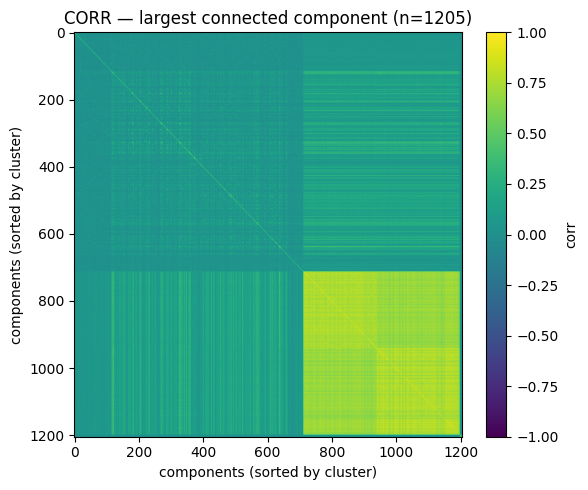

In [40]:
# %%
# Cell F2 — Heatmap of CORR re-ordered by cluster (full and/or largest component)

import numpy as np
import torch
import matplotlib.pyplot as plt

assert all(k in globals() for k in ["CORR_ALL", "global_cluster_ids", "COMPONENTS"])

S = CORR_ALL
labels = np.asarray(global_cluster_ids)

# Order nodes by (cluster_id, then index)
order = np.lexsort((np.arange(len(labels)), labels))
S_ord = S[order][:, order]
labs_ord = labels[order]

def _plot_heatmap(M, title, vmax=1.0):
    plt.figure(figsize=(6, 5))
    plt.imshow(M, vmin=-1.0, vmax=vmax, aspect='auto')
    plt.title(title)
    plt.xlabel("components (sorted by cluster)")
    plt.ylabel("components (sorted by cluster)")
    plt.colorbar(label="corr")
    plt.tight_layout()
    plt.show()

# Full matrix (3000x3000) — can be heavy; uncomment if you want the whole view.
# _plot_heatmap(S_ord.numpy(), "CORR — full (sorted by cluster)")

# Focus on largest connected component for clarity
sizes = [len(c) for c in COMPONENTS]
largest_idx = int(np.argmax(sizes))
largest_nodes = np.array(COMPONENTS[largest_idx], dtype=int)

# reorder those nodes by cluster, then by index
labs_lcc = labels[largest_nodes]
order_lcc = largest_nodes[np.lexsort((largest_nodes, labs_lcc))]
S_lcc = S[np.ix_(order_lcc, order_lcc)]

_plot_heatmap(S_lcc.numpy(), f"CORR — largest connected component (n={len(order_lcc)})")


In [41]:
# %%
# Cell F3 — Top-M most correlated pairs: fraction that land in same cluster

import numpy as np
import torch

assert all(k in globals() for k in ["CORR_ALL", "global_cluster_ids"])

S = CORR_ALL.clone()
C = S.shape[0]
labels = np.asarray(global_cluster_ids)

# ignore diagonal, take absolute or raw? here we use raw corr descending
idx = torch.triu_indices(C, C, offset=1)
vals = S[idx[0], idx[1]]

M = 40000 # top-M pairs
topv, topi = torch.topk(vals, k=min(M, vals.numel()))
pairs = [(int(idx[0, i]), int(idx[1, i])) for i in topi.tolist()]

same = sum(1 for (a,b) in pairs if labels[a] == labels[b])
print(f"[top-pairs] among top-{len(pairs)} corr pairs, same-cluster = {same} "
      f"({same/len(pairs):.3f})")


[top-pairs] among top-40000 corr pairs, same-cluster = 33689 (0.842)


In [42]:
pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SK

In [ ]:
import torch
import numpy as np
from typing import Optional, List, Tuple

# --- reuse existing knobs when already defined ---
W_DIR = 0.6
W_CORR = 0.4
W_COACT = 0.0
AFFINITY_MODE = "shift01"  # {"relu","shift01","threshold"}
ZERO_DIAGONAL = True
N_CLUSTERS = None
RANDOM_SEED = 42
EPS = 1e-8

# --- new knob for threshold-based affinity (only change: affinity construction) ---
THRESHOLD = 0.005  # keep only similarities strictly above this value

print("Multi-Metric Clustering (residual-space geometry + mean-product coactivation)")
print(f"  Weights (dir, corr, coact): {W_DIR}, {W_CORR}, {W_COACT}")
print(f"  Affinity mode: {AFFINITY_MODE} | Zero diag: {ZERO_DIAGONAL} | k: {N_CLUSTERS}")

# ========== Helpers ==========
def _to_numpy(M):
    return M.detach().cpu().numpy() if isinstance(M, torch.Tensor) else np.asarray(M)


def _laplacian_normalized(A: np.ndarray):
    A = A.astype(np.float64, copy=False)
    d = A.sum(axis=1)
    Dinv2 = np.diag(1.0 / (np.sqrt(d) + EPS))  # FIXED: Changed back to 1.0
    L = np.diag(d) - A
    return Dinv2 @ L @ Dinv2, Dinv2


def _auto_k_by_eigengap(evals: np.ndarray, n: int, k_min: int = 2, k_max: Optional[int] = None) -> int:
    if k_max is None:
        k_max = min(60, max(3, int(np.sqrt(n)) * 2))
    k_max = max(k_min, min(k_max, n - 1))

      # Look at gaps between consecutive eigenvalues
    gaps = np.diff(evals[:k_max + 1])

      # Search for largest gap that gives k >= k_min
      # Gap at position i gives k = i+1 clusters
    valid_gaps = gaps[k_min-1:]  # Start from gap that gives k_min clusters
    if len(valid_gaps) == 0:
        return k_min

    best_gap_idx = np.argmax(valid_gaps)
    k = best_gap_idx + k_min
    return int(k)


def _simple_kmeans(X: np.ndarray, k: int, random_seed: int = 42, max_iters: int = 100) -> np.ndarray:
    rng = np.random.RandomState(random_seed)
    n, d = X.shape
    centroids = X[rng.choice(n, k, replace=False)]
    for _ in range(max_iters):
        dists = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
        labels = np.argmin(dists, axis=1)
        new_centroids = np.vstack([
            X[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i] for i in range(k)
        ])
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    return labels


def spectral_cluster_auto_k(
    A_torch: torch.Tensor,
    n_clusters: Optional[int],
    random_seed: int = 42,
    k_min: int = 2,
    k_max: Optional[int] = None,
    return_details: bool = False
):
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    A = _to_numpy(A_torch)
    n = A.shape[0]
    L_norm, _ = _laplacian_normalized(A)
    evals, evecs = np.linalg.eigh(L_norm)  # ascending
    k = _auto_k_by_eigengap(evals, n, k_min=k_min, k_max=k_max) if n_clusters is None else int(n_clusters)
    print(f"Using k = {k} ({'auto' if n_clusters is None else 'manual'})")
    X = evecs[:, :k]
    X = X / (np.linalg.norm(X, axis=1, keepdims=True) + EPS)
    labels = _simple_kmeans(X, k, random_seed=random_seed)
    if return_details:
        return labels, k, {"eigenvalues": evals, "spectral_embedding": X}
    return labels, k, None


# ========== Similarities ==========
def _collect_candidate_dims(labels_all: List[str], sd) -> List[int]:
    dims = []
    for label in labels_all:
        try:
            module_part, idx_part = label.split(':')
            comp_idx = int(idx_part)
            U_key = f"{module_part}.components.U"
            V_key = f"{module_part}.components.V"
            if U_key in sd:
                U = sd[U_key]
                if 0 <= comp_idx < U.shape[0]:
                    dims.append(int(U.shape[1]))  # length of U-row
            if V_key in sd:
                V = sd[V_key]
                if 0 <= comp_idx < V.shape[1]:
                    dims.append(int(V.shape[0]))  # length of V-col
        except Exception:
            pass
    return dims


def _mode(values: List[int]) -> Optional[int]:
    if not values:
        return None
    vals, counts = np.unique(values, return_counts=True)
    return int(vals[np.argmax(counts)])


def compute_directional_similarity_in_residual_space(labels_all: List[str], model) -> torch.Tensor:
    """
    Geometric term in a shared residual space:
      - prefer U row if its length equals inferred residual_dim
      - else use V column if that matches residual_dim
      - else fallback to zero vector of residual_dim
    """
    sd = model.patched_model.state_dict()
    candidate_dims = _collect_candidate_dims(labels_all, sd)
    residual_dim = _mode(candidate_dims)
    if residual_dim is None:
        raise RuntimeError("Could not infer residual dimension from U/V candidates.")
    print(f"[geometry] inferred residual_dim = {residual_dim}")

    vecs = []
    for label in labels_all:
        v_resid = None
        try:
            module_part, idx_part = label.split(':')
            comp_idx = int(idx_part)
            U_key = f"{module_part}.components.U"
            V_key = f"{module_part}.components.V"

            # candidate from U (row)
            if U_key in sd:
                U = sd[U_key]
                if 0 <= comp_idx < U.shape[0] and U.shape[1] == residual_dim:
                    v_resid = U[comp_idx, :].detach().cpu()

            # fallback candidate from V (column) if needed
            if v_resid is None and V_key in sd:
                V = sd[V_key]
                if 0 <= comp_idx < V.shape[1] and V.shape[0] == residual_dim:
                    v_resid = V[:, comp_idx].detach().cpu()

        except Exception:
            v_resid = None

        if v_resid is None:
            v_resid = torch.zeros(residual_dim)  # consistent length
        vecs.append(v_resid)

    M = torch.stack(vecs)  # (C, residual_dim)
    norms = torch.norm(M, dim=1, keepdim=True) + EPS
    Mhat = M / norms
    S = Mhat @ Mhat.T
    print(f"  Directional similarity range: [{float(S.min()):.3f}, {float(S.max()):.3f}]")
    return S


def compute_correlation_similarity_from_X(activations: torch.Tensor) -> torch.Tensor:
    """Pearson corr of gate profiles (uses your corr_matrix)."""
    S = corr_matrix(activations).detach().cpu()
    print(f"  Correlation similarity range: [{float(S.min()):.3f}, {float(S.max()):.3f}]")
    return S


def compute_coactivation_similarity_mean_product(activations: torch.Tensor) -> torch.Tensor:
    """Joint necessity: E[g_i g_j] via mean of elementwise products."""
    n = activations.shape[0]
    S = (activations.T @ activations) / float(n)
    print(f"  Coactivation similarity range: [{float(S.min()):.3f}, {float(S.max()):.3f}]")
    return S


def fuse_similarities(S_dir: torch.Tensor, S_corr: torch.Tensor, S_co: torch.Tensor,
                      w_dir: float, w_corr: float, w_co: float) -> torch.Tensor:
    total = w_dir + w_corr + w_co + EPS
    w_dir, w_corr, w_co = w_dir / total, w_corr / total, w_co / total
    return w_dir * S_dir + w_corr * torch.abs(S_corr) + w_co * S_co


def build_affinity(S: torch.Tensor, mode: str = "relu", zero_diag: bool = True, threshold: Optional[float] = None) -> torch.Tensor:
    """
    Build graph affinity from similarity S.
    Modes:
      - 'relu'    : clamp negatives to 0
      - 'shift01' : map [-1,1] -> [0,1]
      - 'threshold': keep only entries strictly greater than threshold (sparse)
                     uses global THRESHOLD if threshold is None
    """
    A = S.clone()
    if mode == "relu":
        A = torch.clamp(A, min=0.0)
    elif mode == "shift01":
        A = 0.5 * (A + 1.0)
    elif mode == "threshold":
        thr = THRESHOLD if threshold is None else float(threshold)
        A = torch.where(A > thr, A, torch.zeros_like(A))
    else:
        raise ValueError("AFFINITY_MODE must be 'relu', 'shift01', or 'threshold'")
    if zero_diag:
        idx = torch.arange(A.shape[0])
        A[idx, idx] = 0.0

    # lightweight debug for diagnosing spectrum issues (kept inside affinity build)
    try:
        amin, amax = float(A.min()), float(A.max())
        sparsity = float((A == 0).float().mean())
        amean = float(A.mean())
        print(f"  Affinity stats — mode={mode} | thr={THRESHOLD if mode=='threshold' else 'n/a'}")
        print(f"    range: [{amin:.6f}, {amax:.6f}] | sparsity: {sparsity:.3f} | mean: {amean:.6f}")
    except Exception:
        pass

    return A


# ========== Inputs from previous cells ==========
assert "X" in globals() and "LABELS_ALL" in globals() and "MODEL" in globals(), \
    "Run the earlier cells to define X, LABELS_ALL, and MODEL."

C = X.shape[1]
print(f"Input: {X.shape[0]} samples, {C} components")

# ---- Build each similarity ----
print("\n--- Geometric (residual-space) ---")
S_dir = compute_directional_similarity_in_residual_space(LABELS_ALL, MODEL)
\
print("\n--- Activation correlation ---")
S_corr = compute_correlation_similarity_from_X(X)

print("\n--- Joint necessity (mean product) ---")
S_co = compute_coactivation_similarity_mean_product(X)

# ---- Fuse + Cluster ----
S_fused = fuse_similarities(S_dir, S_corr, S_co, W_DIR, W_CORR, W_COACT)
A = build_affinity(S_fused, mode=AFFINITY_MODE, zero_diag=ZERO_DIAGONAL)  # uses THRESHOLD when mode='threshold'
labels_multi, k_multi, details_multi = spectral_cluster_auto_k(
    A, n_clusters=N_CLUSTERS, random_seed=RANDOM_SEED, k_min=2, k_max=None, return_details=True
)

print(f"\nFound {k_multi} clusters")

# ========== DEBUG SECTION (MOVED TO CORRECT POSITION) ==========
evals = details_multi["eigenvalues"]
print(f"\nDEBUG Eigenvalues:")
print(f"First 20 eigenvalues: {evals[:20]}")
gaps = np.diff(evals[:20])
print(f"First 19 gaps: {gaps}")
print(f"Gap positions: {np.arange(len(gaps))}")
print(f"Largest gap position: {np.argmax(gaps)} (should give k={np.argmax(gaps) + 1})")

# Manual k calculation
k_manual = np.argmax(gaps[:10]) + 1  # Look at first 10 gaps
print(f"Manual k calculation: {k_manual}")

MULTI_METRIC_RESULTS = {
    "cluster_labels": labels_multi,
    "n_clusters": k_multi,
    "S_dir": S_dir,
    "S_corr": S_corr,
    "S_co": S_co,
    "S_fused": S_fused,
    "A": A,
    "weights": {"directional": W_DIR, "correlation": W_CORR, "coactivation": W_COACT},
    "spectral_embedding_multi": details_multi.get("spectral_embedding"),
    "eigenvalues_multi": details_multi.get("eigenvalues"),
}
print("Saved to MULTI_METRIC_RESULTS")

# ========== CLUSTER ANALYSIS ==========
print("\n=== Testing Hypothesis: 2 Clusters = Linear vs Doubling Components ===")

  # Analyze which inputs activate each cluster
cluster_0_mask = (labels_multi == 0)
cluster_1_mask = (labels_multi == 1)

print(f"Cluster 0: {cluster_0_mask.sum()} components")
print(f"Cluster 1: {cluster_1_mask.sum()} components")

  # Check activation patterns for positive vs negative inputs
pos_inputs = (X > 0).float().mean(dim=0)  # Fraction of time each component sees positive input
print(f"Cluster 0 positive activation rate: {pos_inputs[cluster_0_mask].mean():.3f}")
print(f"Cluster 1 positive activation rate: {pos_inputs[cluster_1_mask].mean():.3f}")

  # Check activation magnitudes
activation_means = X.mean(dim=0)
print(f"Cluster 0 mean activation: {activation_means[cluster_0_mask].mean():.6f}")
print(f"Cluster 1 mean activation: {activation_means[cluster_1_mask].mean():.6f}")

  # Check activation sparsity
sparsity = (X == 0).float().mean(dim=0)
print(f"Cluster 0 sparsity (fraction zeros): {sparsity[cluster_0_mask].mean():.3f}")
print(f"Cluster 1 sparsity (fraction zeros): {sparsity[cluster_1_mask].mean():.3f}")

print("=== End Cluster Analysis ===")

print("\n=== Module Distribution Analysis ===")
for cluster_id in [0, 1]:
    mask = (labels_multi == cluster_id)
    cluster_labels = [LABELS_ALL[i] for i in range(len(LABELS_ALL)) if mask[i]]

      # Extract module names
    modules = [label.split(':')[0] for label in cluster_labels[:10]]  # First 10 examples
    print(f"Cluster {cluster_id} modules (first 10): {modules}")

print("=== Architecture Verification ===")
print(f"Input data X shape: {X.shape}")  # Should be (samples, ~3000)
print(f"Number of SPD components: {len(LABELS_ALL)}")
print(f"Residual dim inferred: 17")  # This seems wrong for 1000D residual stream!

  # Check the actual model architecture
if hasattr(MODEL, 'patched_model'):
    sd = MODEL.patched_model.state_dict()
    for key in sd.keys():
        if 'mlp_in' in key and 'components' in key:
            print(f"Model component {key}: {sd[key].shape}")


Multi-Metric Clustering (residual-space geometry + mean-product coactivation)
  Weights (dir, corr, coact): 0.6, 0.4, 0.0
  Affinity mode: shift01 | Zero diag: True | k: None
Input: 4096 samples, 3000 components

--- Geometric (residual-space) ---
[geometry] inferred residual_dim = 17
  Directional similarity range: [-0.998, 1.000]

--- Activation correlation ---
  Correlation similarity range: [-0.437, 1.000]

--- Joint necessity (mean product) ---
  Coactivation similarity range: [0.000, 0.108]
  Affinity stats — mode=shift01 | thr=n/a
    range: [0.000000, 0.984102] | sparsity: 0.000 | mean: 0.506938
Using k = 2 (auto)

Found 2 clusters

DEBUG Eigenvalues:
First 20 eigenvalues: [1.18126370e-18 8.76953941e-01 9.61837710e-01 9.63507666e-01
 9.65790578e-01 9.67330439e-01 9.68312475e-01 9.68587691e-01
 9.69412348e-01 9.70775665e-01 9.70965611e-01 9.71317039e-01
 9.72834097e-01 9.73385144e-01 9.74000298e-01 9.74845766e-01
 9.75533697e-01 9.77389340e-01 9.78280439e-01 9.97129809e-01]
Firs

In [75]:
# MINIMAL TEST - Add this to a new cell to debug
print("=== MINIMAL CLUSTERING TEST ===")

  # Test 1: Check if corr_matrix exists
try:
    test_corr = corr_matrix(X[:100, :10])  # Small test
    print("✓ corr_matrix function exists")
except NameError:
    print("✗ ERROR: corr_matrix function is NOT DEFINED!")
    print("This is why your correlation similarity is broken")

  # Test 2: Simple synthetic data test
print("\n--- Testing with synthetic data ---")
np.random.seed(42)
n_synthetic = 300
synthetic_data = np.random.randn(100, n_synthetic)

  # Create 5 clear clusters in synthetic data
for i in range(5):
    start, end = i*60, (i+1)*60
    synthetic_data[:, start:end] += i * 3  # Separate clusters

synthetic_tensor = torch.tensor(synthetic_data, dtype=torch.float32)

  # Simple correlation similarity
S_synthetic = torch.corrcoef(synthetic_tensor.T)
print(f"Synthetic correlation range: [{S_synthetic.min():.3f}, {S_synthetic.max():.3f}]")

  # Test clustering on synthetic
A_synthetic = torch.clamp(S_synthetic, min=0.1)  # Simple threshold
A_synthetic.fill_diagonal_(0)

  # Manual eigenvalue check
L_synthetic = torch.diag(A_synthetic.sum(dim=1)) - A_synthetic
D_inv_sqrt = torch.diag(1.0 / torch.sqrt(A_synthetic.sum(dim=1) + 1e-8))
L_norm_synthetic = D_inv_sqrt @ L_synthetic @ D_inv_sqrt

evals_synthetic = torch.linalg.eigvals(L_norm_synthetic).real
evals_sorted = torch.sort(evals_synthetic)[0][:20]
print(f"Synthetic eigenvalues: {evals_sorted}")

gaps_synthetic = torch.diff(evals_sorted[:10])
k_synthetic = torch.argmax(gaps_synthetic) + 1
print(f"Synthetic data should give k={k_synthetic} clusters")

print("=== END TEST ===")

=== MINIMAL CLUSTERING TEST ===
✓ corr_matrix function exists

--- Testing with synthetic data ---
Synthetic correlation range: [-0.391, 1.000]
Synthetic eigenvalues: tensor([    0.000000,     0.969162,     0.969386,     0.969968,     0.971992,     0.972447,     0.973690,     0.974121,     0.974643,     0.974905,
            0.975469,     0.976422,     0.976629,     0.976931,     0.977504,     0.977769,     0.978365,     0.978641,     0.979283,     0.979750])
Synthetic data should give k=1 clusters
=== END TEST ===


In [55]:
print("=== DEBUGGING THE CLUSTERING ISSUE ===")

print(f"\n1. Input data X shape: {X.shape}")
print(f"   X mean: {X.mean():.6f}, std: {X.std():.6f}")
print(f"   X sparsity (zeros): {(X == 0).float().mean():.3f}")
print(f"   X range: [{X.min():.6f}, {X.max():.6f}]")

print(f"\n2. Similarity matrices:")
print(f"   S_dir shape: {S_dir.shape}, range: [{S_dir.min():.3f}, {S_dir.max():.3f}]")
print(f"   S_corr shape: {S_corr.shape}, range: [{S_corr.min():.3f}, {S_corr.max():.3f}]")
print(f"   S_co shape: {S_co.shape}, range: [{S_co.min():.3f}, {S_co.max():.3f}]")

print(f"\n3. Fused similarity:")
print(f"   S_fused range: [{S_fused.min():.6f}, {S_fused.max():.6f}]")
print(f"   S_fused mean: {S_fused.mean():.6f}, std: {S_fused.std():.6f}")

print(f"\n4. Affinity matrix A:")
print(f"   A range: [{A.min():.6f}, {A.max():.6f}]")
print(f"   A sparsity (zeros): {(A == 0).float().mean():.3f}")
print(f"   A mean: {A.mean():.6f}")

# Check eigenvalues directly
L_norm, _ = MULTI_METRIC_RESULTS["eigenvalues_multi"], None
if hasattr(details_multi, 'get') and details_multi.get("eigenvalues") is not None:
    evals = details_multi["eigenvalues"][:20]  # first 20 eigenvalues
    print(f"\n5. First 20 eigenvalues of Laplacian:")
    print([f"{e:.4f}" for e in evals])
    # Manual eigengap calculation
    gaps = np.diff(evals[:10])
    print(f"\n6. First 10 eigengaps:")
    print([f"{g:.4f}" for g in gaps])
    print(f"   Largest gap at position: {np.argmax(gaps)} (gives k={np.argmax(gaps)+1})")

# Check if graph is connected
row_sums = A.sum(dim=1)
isolated_nodes = (row_sums == 0).sum()
print(f"\n7. Graph connectivity:")
print(f"   Isolated nodes (zero row sum): {isolated_nodes}")
print(f"   Min/max row sum: {row_sums.min():.6f} / {row_sums.max():.6f}")

print("\n=== END DEBUG ===\n")


=== DEBUGGING THE CLUSTERING ISSUE ===

1. Input data X shape: torch.Size([4096, 3000])
   X mean: 0.003380, std: 0.046785
   X sparsity (zeros): 0.883
   X range: [0.000000, 1.000000]

2. Similarity matrices:
   S_dir shape: torch.Size([3000, 3000]), range: [-0.998, 1.000]
   S_corr shape: torch.Size([3000, 3000]), range: [-0.437, 1.000]
   S_co shape: torch.Size([3000, 3000]), range: [0.000, 0.108]

3. Fused similarity:
   S_fused range: [-0.098328, 0.286025]
   S_fused mean: 0.003626, std: 0.032058

4. Affinity matrix A:
   A range: [0.000000, 0.193940]
   A sparsity (zeros): 0.986
   A mean: 0.002289

5. First 20 eigenvalues of Laplacian:
['-0.0000', '-0.0000', '-0.0000', '-0.0000', '-0.0000', '-0.0000', '-0.0000', '-0.0000', '-0.0000', '-0.0000', '-0.0000', '-0.0000', '-0.0000', '-0.0000', '-0.0000', '-0.0000', '-0.0000', '-0.0000', '-0.0000', '-0.0000']

6. First 10 eigengaps:
['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
   Largest ga